In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

import pickle

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Data: Superstore sales dataset
path = '/content/drive/MyDrive/TimeSeriesProjects/Data/Superstore.xls'
df = pd.read_excel(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [3]:
df.head().T

,0,1,2,3,4
Row ID,1,2,3,4,5
Order ID,CA-2016-152156,CA-2016-152156,CA-2016-138688,US-2015-108966,US-2015-108966
Order Date,2016-11-08 00:00:00,2016-11-08 00:00:00,2016-06-12 00:00:00,2015-10-11 00:00:00,2015-10-11 00:00:00
Ship Date,2016-11-11 00:00:00,2016-11-11 00:00:00,2016-06-16 00:00:00,2015-10-18 00:00:00,2015-10-18 00:00:00
Ship Mode,Second Class,Second Class,Second Class,Standard Class,Standard Class
Customer ID,CG-12520,CG-12520,DV-13045,SO-20335,SO-20335
Customer Name,Claire Gute,Claire Gute,Darrin Van Huff,Sean O'Donnell,Sean O'Donnell
Segment,Consumer,Consumer,Corporate,Consumer,Consumer
Country,United States,United States,United States,United States,United States
City,Henderson,Henderson,Los Angeles,Fort Lauderdale,Fort Lauderdale


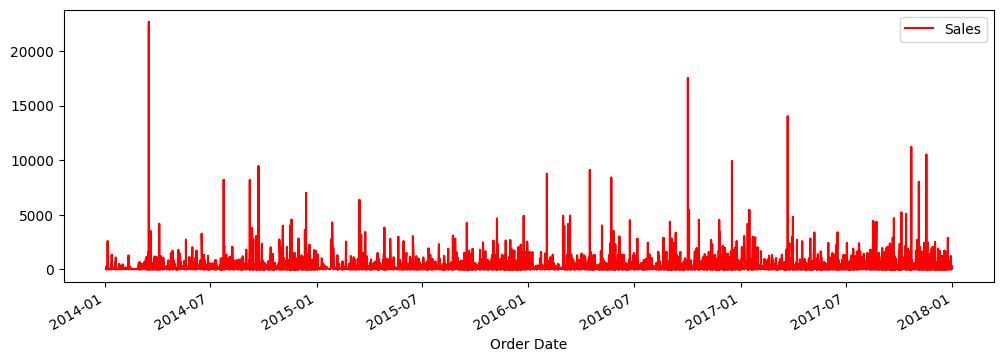

In [4]:
dfsales = df[['Order Date','Sales']]
dfsales.set_index('Order Date',inplace=True)
dfsales.plot(figsize=(12,4),c='red');

In [5]:
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [6]:
df['Category'].value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

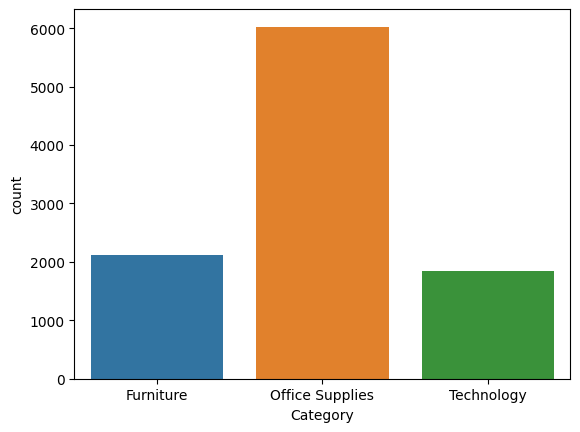

In [7]:
#Plotting number of sales based on category
sns.countplot(data=df,x=df['Category']);

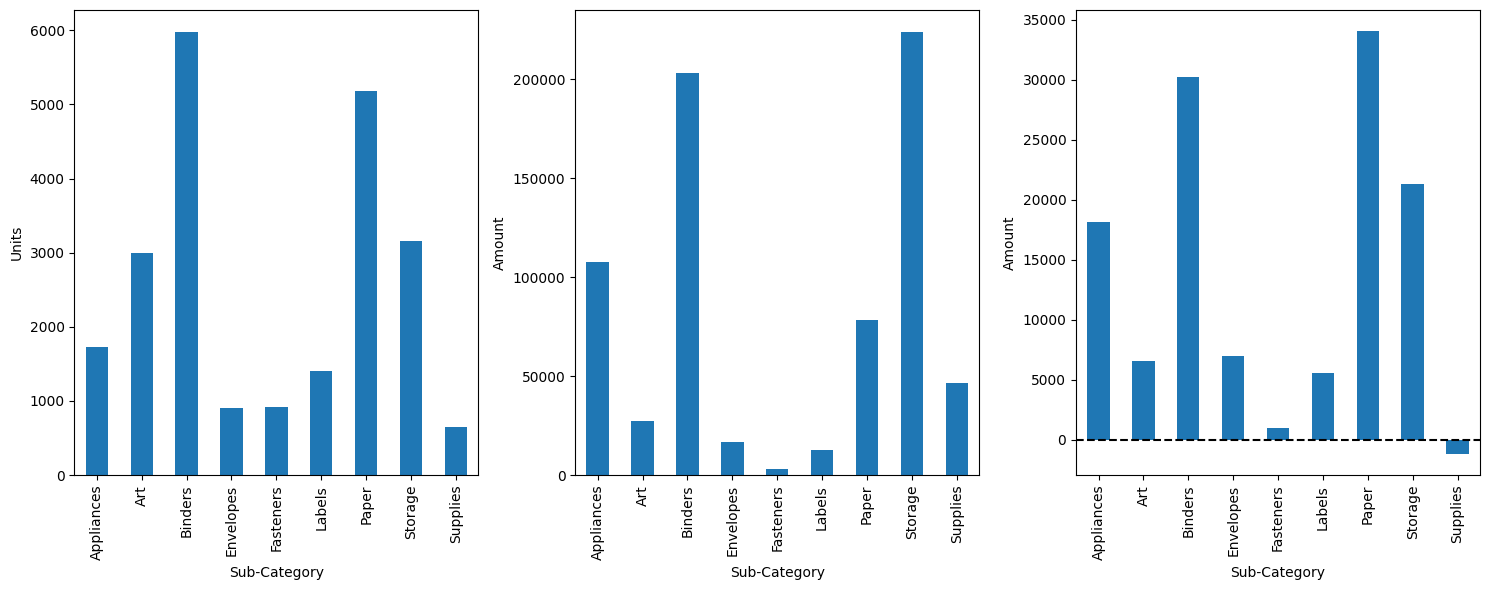

In [8]:
#Subcategories of office supplies
plt.subplots(figsize=(15,6))
plt.subplot(131)
df[df['Category']=='Office Supplies'].groupby(df['Sub-Category'])['Quantity'].sum().plot(kind='bar');
plt.xlabel("Sub-Category")
plt.ylabel('Units')
plt.subplot(132)
df[df['Category']=='Office Supplies'].groupby(df['Sub-Category'])['Sales'].sum().plot(kind='bar');
plt.ylabel('Amount')
plt.subplot(133)
df[df['Category']=='Office Supplies'].groupby(df['Sub-Category'])['Profit'].sum().plot(kind='bar');
plt.ylabel('Amount')
plt.axhline(0, c='black',ls='--')
plt.tight_layout()
plt.show()

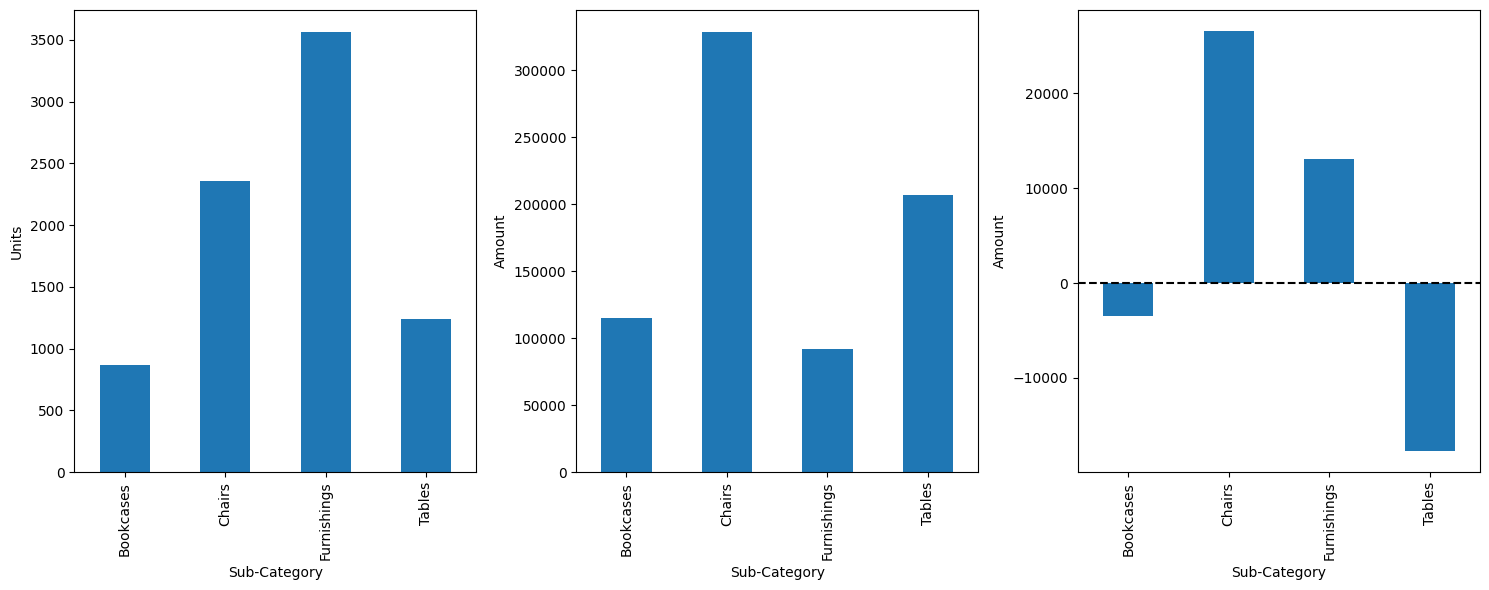

In [9]:
#Subcategories of Furniture
plt.subplots(figsize=(15,6))
plt.subplot(131)
df[df['Category']=='Furniture'].groupby(df['Sub-Category'])['Quantity'].sum().plot(kind='bar');
plt.xlabel("Sub-Category")
plt.ylabel('Units')
plt.subplot(132)
df[df['Category']=='Furniture'].groupby(df['Sub-Category'])['Sales'].sum().plot(kind='bar');
plt.ylabel('Amount')
plt.subplot(133)
df[df['Category']=='Furniture'].groupby(df['Sub-Category'])['Profit'].sum().plot(kind='bar');
plt.ylabel('Amount')
plt.axhline(0, c='black',ls='--')
plt.tight_layout()
plt.show()

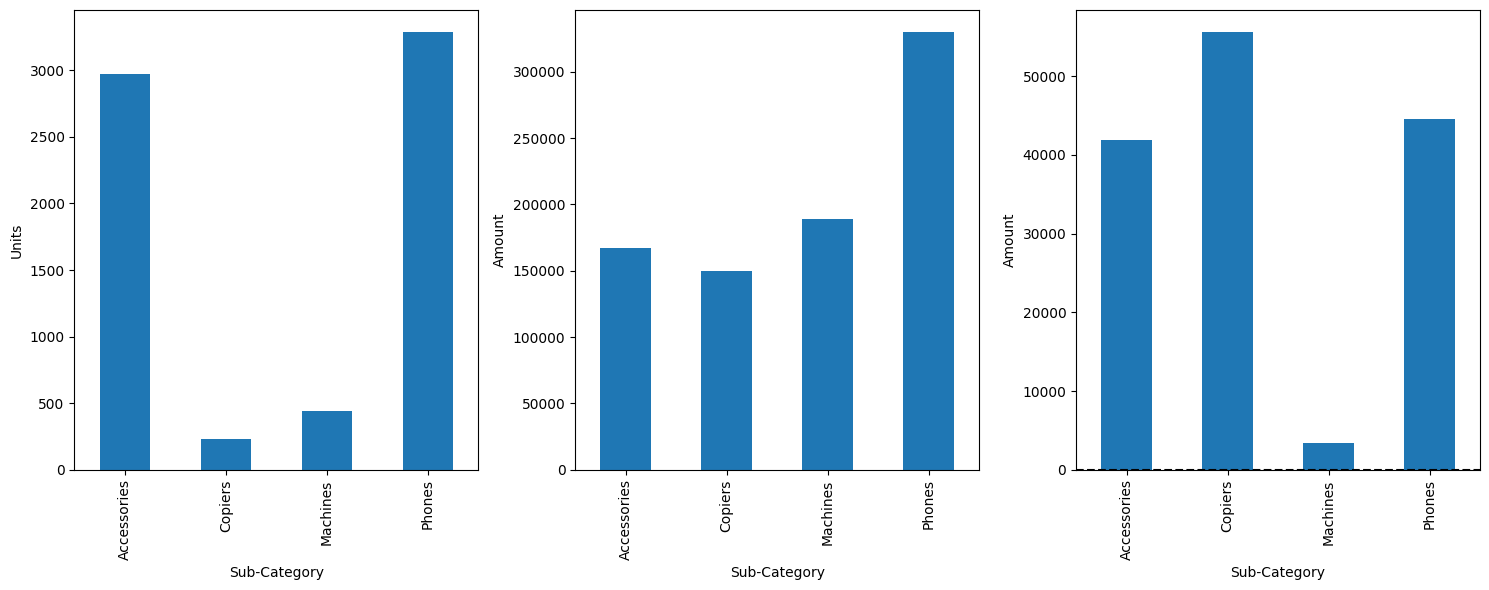

In [10]:
#Subcategories of Technology
plt.subplots(figsize=(15,6))
plt.subplot(131)
df[df['Category']=='Technology'].groupby(df['Sub-Category'])['Quantity'].sum().plot(kind='bar');
plt.xlabel("Sub-Category")
plt.ylabel('Units')
plt.subplot(132)
df[df['Category']=='Technology'].groupby(df['Sub-Category'])['Sales'].sum().plot(kind='bar');
plt.ylabel('Amount')
plt.subplot(133)
df[df['Category']=='Technology'].groupby(df['Sub-Category'])['Profit'].sum().plot(kind='bar');
plt.ylabel('Amount')
plt.axhline(0, c='black',ls='--')
plt.tight_layout()
plt.show()

##furniture sales data

In [8]:
dff = df[df['Category'] == 'Furniture']
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 9990
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         2121 non-null   int64         
 1   Order ID       2121 non-null   object        
 2   Order Date     2121 non-null   datetime64[ns]
 3   Ship Date      2121 non-null   datetime64[ns]
 4   Ship Mode      2121 non-null   object        
 5   Customer ID    2121 non-null   object        
 6   Customer Name  2121 non-null   object        
 7   Segment        2121 non-null   object        
 8   Country        2121 non-null   object        
 9   City           2121 non-null   object        
 10  State          2121 non-null   object        
 11  Postal Code    2121 non-null   int64         
 12  Region         2121 non-null   object        
 13  Product ID     2121 non-null   object        
 14  Category       2121 non-null   object        
 15  Sub-Category   2121 n

In [9]:
#Furniture data availability
dff['Order Date'].min(), dff['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [ ]:
#Almost 4-year furniture sales data

##Data Preprocessing

In [ ]:
#This step includes removing columns we do not need,
#Check missing values, aggregate sales by date.

In [10]:
dff.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [11]:
#Columns we don't need for time series analysis
columns= ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Quantity', 'Discount', 'Profit']
dff.drop(columns, axis=1,inplace=True)
dff = dff.sort_values(by='Order Date')
dff.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


In [12]:
dff.shape

(2121, 2)

In [13]:
#Check for null values
dff.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [14]:
dff = dff.groupby('Order Date')['Sales'].sum().reset_index()
#Set index
dff = dff.set_index('Order Date')
dff.head(10)

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939
2014-01-14,61.960
2014-01-16,127.104
2014-01-19,181.470
2014-01-20,1413.510


In [15]:
dff.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

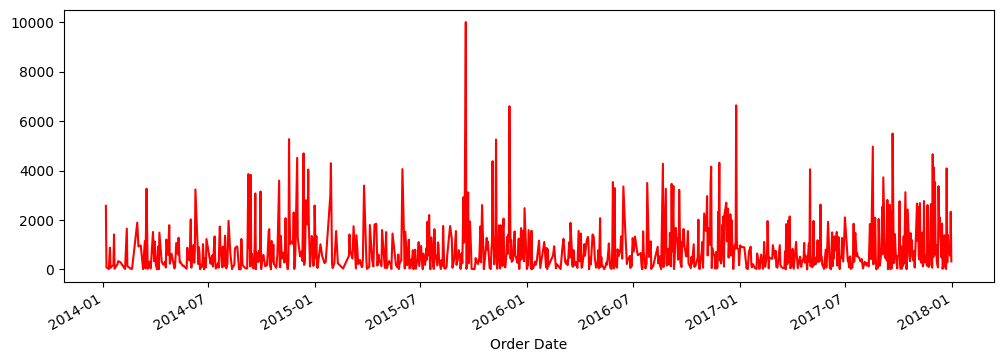

In [16]:
dff.Sales.plot(figsize=(12,4),c='red');

In [20]:
#Since the current date distribution is irregular
#We will consider the average sales in a given month and
#We will choose start of each month as our time stamp

In [17]:
#Resampling of furniture sales by months: 'MS'
dffmean = dff[['Sales']].resample('MS').mean()
dffsum = dff[['Sales']].resample('MS').sum()

In [18]:
dffmean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-01 to 2017-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [19]:
dffmean.tail()

,Sales
Order Date,
2017-08-01,857.881889
2017-09-01,1209.508583
2017-10-01,875.362728
2017-11-01,1277.817759
2017-12-01,1256.298672


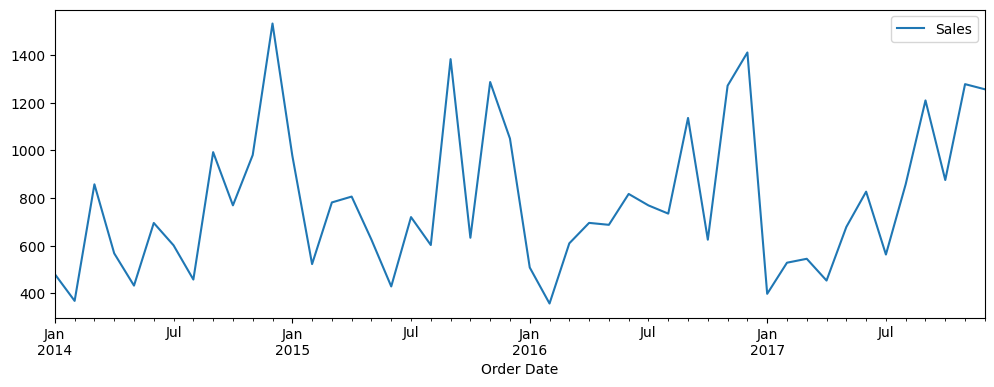

In [20]:
y = dffmean.copy()
y.plot(figsize=(12, 4))
plt.show();

In [21]:
y.columns = ['Furniture_Sales']
y.head()

,Furniture_Sales
Order Date,
2014-01-01,480.194231
2014-02-01,367.931600
2014-03-01,857.291529
2014-04-01,567.488357
2014-05-01,432.049188


In [ ]:
#Seasonality present: Low at the beginning of the year and,
# High towards the end of the year

### Additive Model
###y(t) = Level + Trend + Seasonality + Noise
### Multiplicative Model
###y(t) = Level * Trend * Seasonality * Noise

In [ ]:
#Decomposition: To further evaluating the trend, Seasonality and error (noise)

In [22]:
#Addative decomposition
decompose = seasonal_decompose(y,model='additive',period=12)
print(decompose.trend,'\n')
print(decompose.seasonal,'\n')
print(decompose.resid,'\n')
print(decompose.observed,'\n')

Order Date
2014-01-01           NaN
2014-02-01           NaN
2014-03-01           NaN
2014-04-01           NaN
2014-05-01           NaN
2014-06-01           NaN
2014-07-01    748.471753
2014-08-01    775.663349
2014-09-01    778.930390
2014-10-01    785.692036
2014-11-01    803.662124
2014-12-01    800.597698
2015-01-01    794.432826
2015-02-01    805.408958
2015-03-01    827.714278
2015-04-01    838.314364
2015-05-01    845.416223
2015-06-01    838.063596
2015-07-01    798.351575
2015-08-01    771.865200
2015-09-01    757.815699
2015-10-01    746.061098
2015-11-01    744.053545
2015-12-01    762.829119
2016-01-01    781.053092
2016-02-01    788.591670
2016-03-01    783.802439
2016-04-01    773.179729
2016-05-01    772.202066
2016-06-01    786.619074
2016-07-01    797.068393
2016-08-01    799.598843
2016-09-01    804.032508
2016-10-01    791.241723
2016-11-01    780.781800
2016-12-01    780.806244
2017-01-01    772.611993
2017-02-01    769.168766
2017-03-01    777.382488
2017-04-01    

<Figure size 1500x800 with 0 Axes>

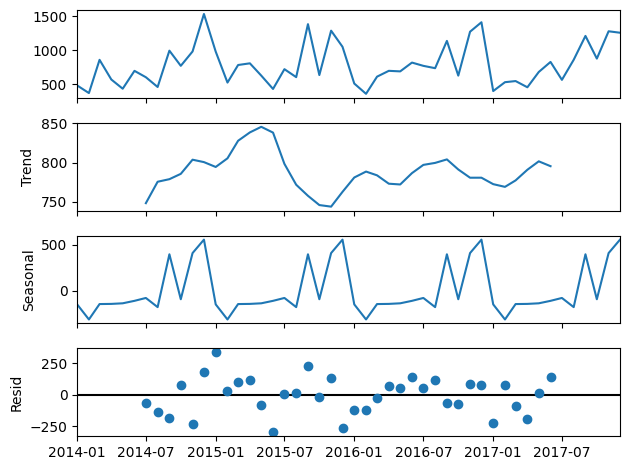

In [23]:
plt.figure(figsize=(15,8))
decompose.plot(observed=True,
               seasonal=True,
               trend=True,
               resid=True,
               weights=False)
plt.show();

In [24]:
#Multiplicative decomposition
decompose = seasonal_decompose(y,model='multiplicative',period=12)
print(decompose.trend,'\n')
print(decompose.seasonal,'\n')
print(decompose.resid,'\n')
print(decompose.observed,'\n')

Order Date
2014-01-01           NaN
2014-02-01           NaN
2014-03-01           NaN
2014-04-01           NaN
2014-05-01           NaN
2014-06-01           NaN
2014-07-01    748.471753
2014-08-01    775.663349
2014-09-01    778.930390
2014-10-01    785.692036
2014-11-01    803.662124
2014-12-01    800.597698
2015-01-01    794.432826
2015-02-01    805.408958
2015-03-01    827.714278
2015-04-01    838.314364
2015-05-01    845.416223
2015-06-01    838.063596
2015-07-01    798.351575
2015-08-01    771.865200
2015-09-01    757.815699
2015-10-01    746.061098
2015-11-01    744.053545
2015-12-01    762.829119
2016-01-01    781.053092
2016-02-01    788.591670
2016-03-01    783.802439
2016-04-01    773.179729
2016-05-01    772.202066
2016-06-01    786.619074
2016-07-01    797.068393
2016-08-01    799.598843
2016-09-01    804.032508
2016-10-01    791.241723
2016-11-01    780.781800
2016-12-01    780.806244
2017-01-01    772.611993
2017-02-01    769.168766
2017-03-01    777.382488
2017-04-01    

<Figure size 1500x800 with 0 Axes>

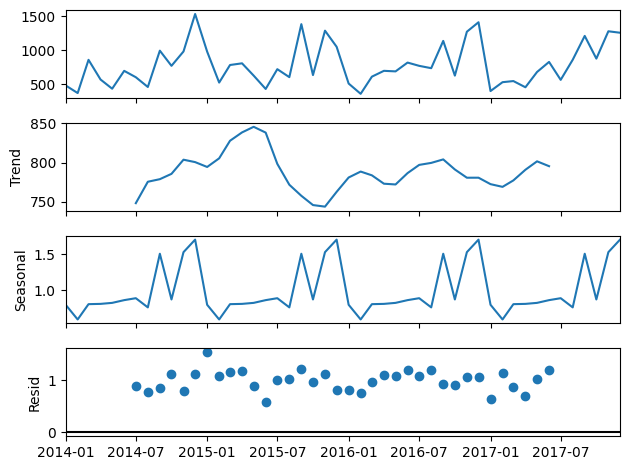

In [25]:
plt.figure(figsize=(15,8))
decompose.plot(observed=True,
               seasonal=True,
               trend=True,
               resid=True,
               weights=False)
plt.show();

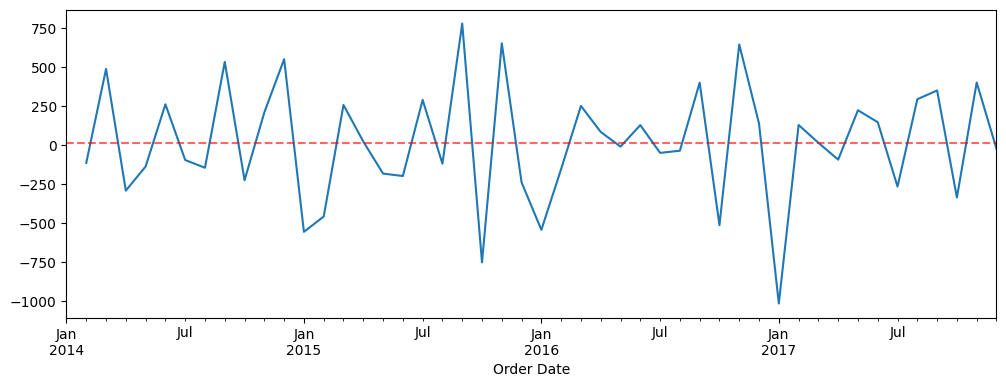

In [26]:
#As there is a clear non-seasonality,
#Let's see if 1st differencing can make the time series stationary
y['difference'] = y['Furniture_Sales'].diff(1)
y['difference'].plot(figsize=(12,4))
plt.axhline(float(y['difference'].mean()), c='red', alpha=0.6, ls='--')
plt.show()

##Adfuller test

In [27]:
#Adfuller test function
def adfull(x):
  result = adfuller(x)
  if result[1]<0.05:
    print('p-value: ',result[1])
    print('Stationary')
  else:
    print('p-value: ',result[1])
    print('Non-Stationary')

  return None


In [28]:
adfull(y['difference'].dropna())


p-value:  8.174524526853214e-10
Stationary


In [ ]:
#So first differencing makes the time series stationary.

##ACF/PACF plot

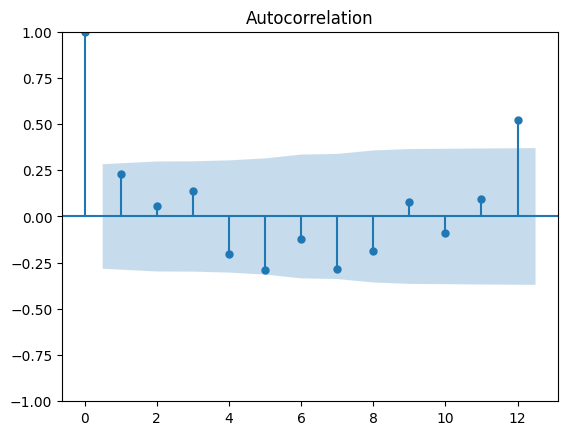

In [32]:
#ACF plot
plot_acf(y['Furniture_Sales'],lags=12);

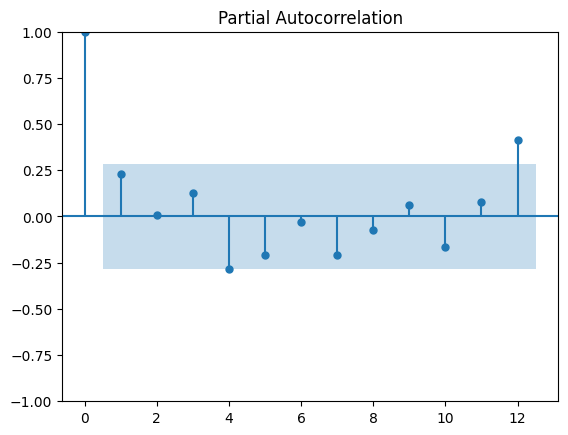

In [33]:
#PACF plot
plot_pacf(y['Furniture_Sales'],lags=12);

In [ ]:
#No significant peaks in either of acf or pacf plot
# We In ARIMA model we will use p,q in range(0,3) and d =0,1

In [34]:
y.shape

(48, 2)

##Train and Test split

In [29]:
#Train test split
ntest = 12
train = y.iloc[:-ntest]
test = y.iloc[-ntest:]

In [30]:
#Indexing
train_idx = y.index <= train.index[-1]
test_idx = ~train_idx

##Naive forecast

In [31]:
len(test)

12

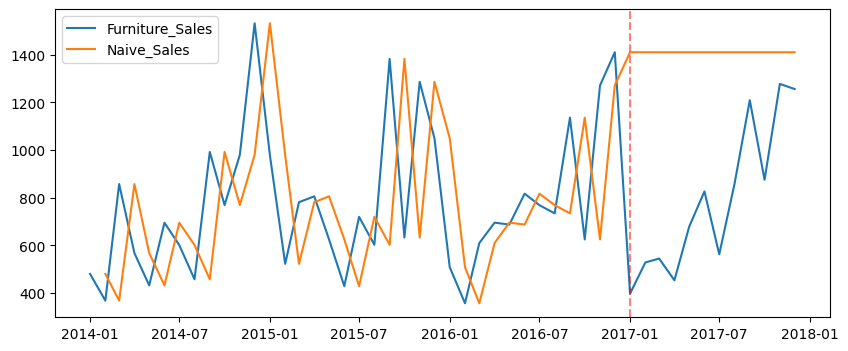

In [32]:
#Naive forecast is nothing but forecast with 1 lag
y.loc[train_idx,'Naive_Sales']= train['Furniture_Sales'].shift(1)
y.loc[test_idx,'Naive_Sales'] = train.iloc[-1]['Furniture_Sales']
y['Naive_Sales']
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(y.index, y[['Furniture_Sales','Naive_Sales']], label=['Furniture_Sales','Naive_Sales'])
plt.axvline(test.index[0],c='red',alpha=0.5, ls='--')
ax.legend()

##ARIMA model

In [33]:
p= q = range(0,3)
d =range(0,2)
pdq = list(itertools.product(p,d,q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]


In [34]:
AIC = 1000000
order = (10,10,10)
for values in pdq:
  model = ARIMA(train['Furniture_Sales'],order=values)
  res = model.fit()

  print(f'ARIMA{values} - Summary: ', res.summary().tables[1])
  print('**************************************************************')
  print('**************************************************************')
  if res.aic < AIC:
      AIC = res.aic
      order = values
print(f'ARIMA{order} - AIC: ', AIC)

ARIMA(0, 0, 0) - Summary:  ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        782.4443     63.919     12.241      0.000     657.165     907.724
sigma2       9.22e+04   2.84e+04      3.249      0.001    3.66e+04    1.48e+05
**************************************************************
**************************************************************
ARIMA(0, 0, 1) - Summary:  ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        783.0650     79.750      9.819      0.000     626.757     939.373
ma.L1          0.2088      0.156      1.341      0.180      -0.096       0.514
sigma2      8.821e+04   2.91e+

##Fitting the ARIMA model

In [35]:
#Based on AIC values and p-values the order we will use
pdq = order
model1 = ARIMA(train['Furniture_Sales'],order=pdq)
res1 = model1.fit()
print(res1.summary())

                               SARIMAX Results                                
Dep. Variable:        Furniture_Sales   No. Observations:                   36
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -251.275
Date:                Sat, 07 Oct 2023   AIC                            506.551
Time:                        05:12:28   BIC                            509.662
Sample:                    01-01-2014   HQIC                           507.625
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6885      0.143     -4.806      0.000      -0.969      -0.408
sigma2      9.895e+04    2.4e+04      4.130      0.000     5.2e+04    1.46e+05
Ljung-Box (L1) (Q):                   0.01   Jarque-

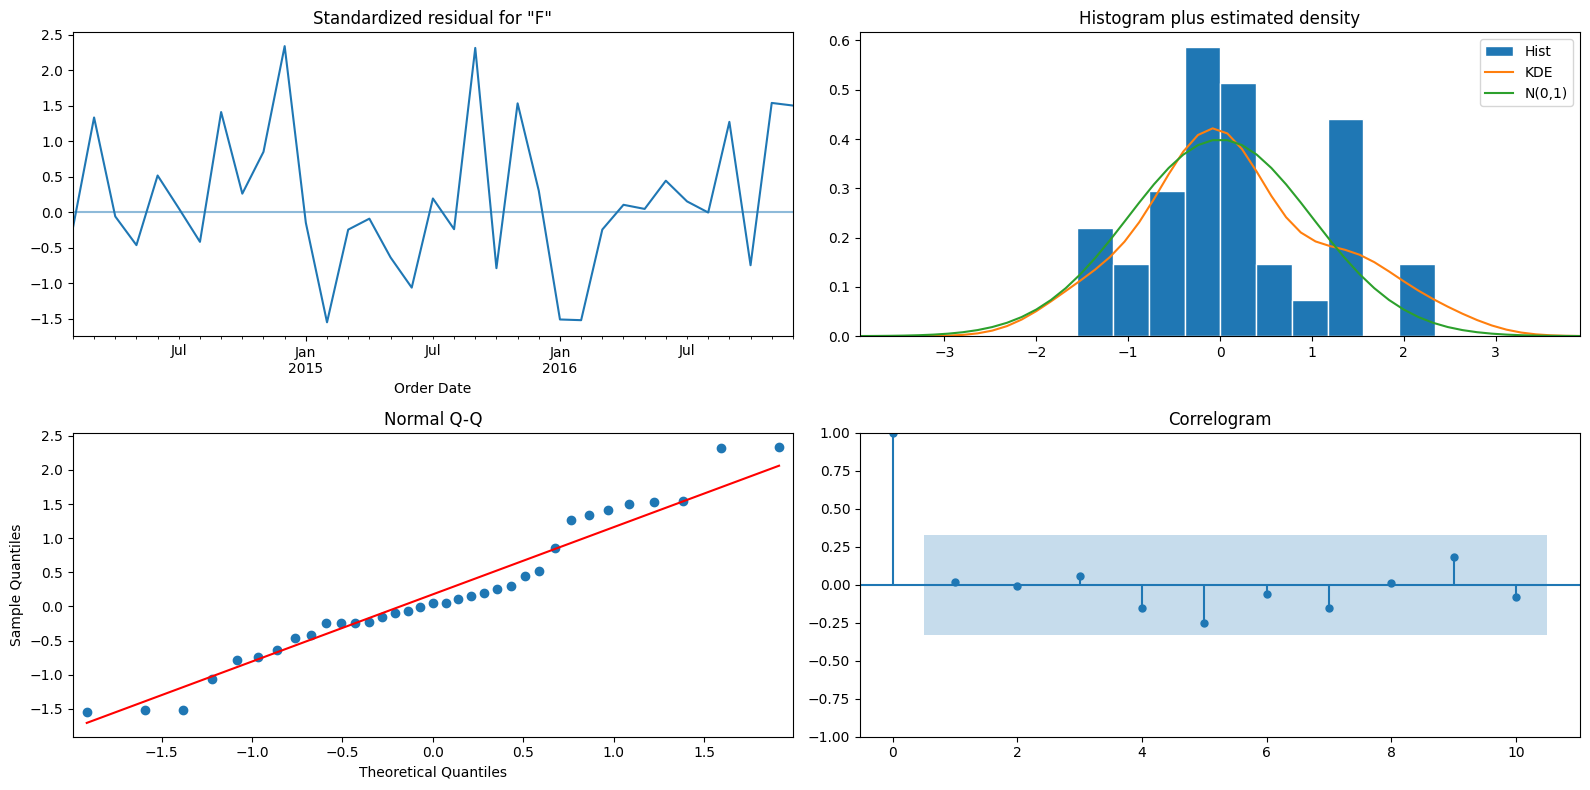

In [36]:
res1.plot_diagnostics(figsize=(16, 8))
plt.tight_layout()
plt.show()

In [ ]:
#Model diagnostics suggests that the model residuals are near normally distributed.

###forecasts

In [37]:
#ts = time_series
#result = model.fit()
#model_name

In [38]:
def plot_fit_and_forecast(df,result,ts, model_name):
  fit = result.fittedvalues
  forecast = result.get_forecast(12)
  pred = forecast.predicted_mean
  upper,lower = forecast.conf_int().iloc[:,1],forecast.conf_int().iloc[:,0]
  prediction = pd.concat([fit,pred])
  df[model_name] = prediction
  fig, ax = plt.subplots(figsize=(10,4))
  ax.plot(df.index, df[[ts,model_name]], label=[ts,model_name])
  ax.fill_between(test.index,lower,upper,color='pink',alpha=0.6)
  plt.axvline(test.index[0],c='red',alpha=0.5, ls='--')
  ax.legend()

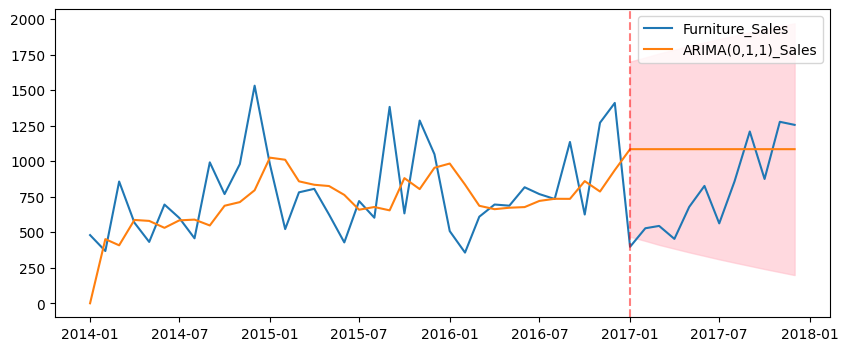

In [39]:
plot_fit_and_forecast(y, res1,'Furniture_Sales','ARIMA(0,1,1)_Sales')

In [ ]:
with open('/content/drive/MyDrive/TimeSeriesProjects/models/ARIMA.pckl', 'wb') as fout: # saving the model in models directory
    pickle.dump(model1, fout)

##SARIMA model

In [40]:
p= q = range(0,3)
d =range(0,2)
pdq = list(itertools.product(p,d,q))
print(pdq)
P = Q = range(0,2)
D =range(0,2)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P,D,Q))]
print(seasonal_pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [41]:
AIC = 1000000
order = (10,10,10)
season_order = (10,10,10,12)
for param in pdq:
  for seasonal_param in seasonal_pdq:
    model2 = SARIMAX(train['Furniture_Sales'],
                     order=param,
                     seasonal_order=seasonal_param,
                    enforce_stationarity=False,
                # enforce_invertibility=False
                    # initialization='approximate_diffuse'
                     )
    res2 = model2.fit()

    if res2.aic < AIC:
      AIC = res2.aic
      order = param
      season_order = seasonal_param
print(f'SARIMA{order}x{season_order} - AIC: ', AIC)
model_name = f'SARIMA{order}x{season_order}'

SARIMA(1, 1, 2)x(0, 1, 1, 12) - AIC:  103.19461231406237


####Fitting the SARIMA model

In [42]:
model2 = SARIMAX(train['Furniture_Sales'],
                     order=order,
                     seasonal_order=season_order,
                 enforce_stationarity=False,
                     )
res2 = model2.fit()
print(res2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                      Furniture_Sales   No. Observations:                   36
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 -46.597
Date:                              Sat, 07 Oct 2023   AIC                            103.195
Time:                                      05:13:21   BIC                            103.592
Sample:                                  01-01-2014   HQIC                           100.516
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8383      0.121     -6.945      0.000      -1.075      -0.602
ma.L1          1.40

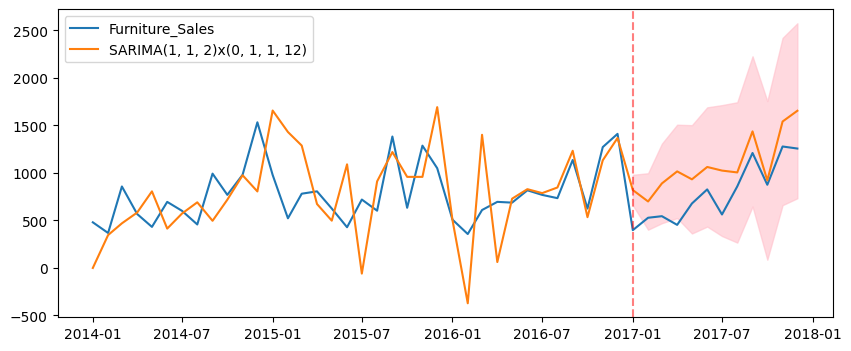

In [43]:
plot_fit_and_forecast(y, res2,'Furniture_Sales',model_name)

In [ ]:
with open('/content/drive/MyDrive/TimeSeriesProjects/models/SARIMA.pckl', 'wb') as fout: # saving the model in models directory
    pickle.dump(model2, fout)

In [44]:
res2.predict(start=pd.to_datetime('2017-02-01'),end=pd.to_datetime('2017-06-01'), freq='M')

2017-02-01     699.488236
2017-03-01     889.262063
2017-04-01    1015.852364
2017-05-01     932.367434
2017-06-01    1062.412973
Freq: MS, Name: predicted_mean, dtype: float64

##Auto-ARIMA

In [45]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.6 MB/s eta 0:00:00


In [46]:
import pmdarima as pmd

In [56]:
model3 = pmd.auto_arima(train['Furniture_Sales'],trace=True,seasonal=True,m=12, stepwise=False)

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=338.682, Time=0.01 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=329.174, Time=0.24 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=331.153, Time=0.73 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=332.939, Time=1.10 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=335.278, Time=1.80 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=340.166, Time=0.18 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=330.964, Time=0.58 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=334.701, Time=0.89 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   :

In [48]:
print(model3.summary())

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   36
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                -161.587
Date:                  Fri, 06 Oct 2023   AIC                            329.174
Time:                          17:14:06   BIC                            332.708
Sample:                      01-01-2014   HQIC                           330.111
                           - 12-01-2016                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     74.0416     48.625      1.523      0.128     -21.261     169.344
ar.S.L12      -0.7870      0.131     -6.027      0.000      -1.043      -0.531
sigma2      2.557e+04   1.31e+04    

In [49]:
fit = model3.predict_in_sample(start=train.index[0],end=train.index[-1])

In [50]:
forecast,conf_int = model3.predict(n_periods=12,return_conf_int=True)

In [51]:
conf_int = pd.DataFrame(conf_int, index=test.index,columns=['lower','upper'])

In [52]:
lower,upper = conf_int.iloc[:,0],conf_int.iloc[:,1]

In [53]:
y['Auto-ARIMA'] = pd.concat([fit,forecast])

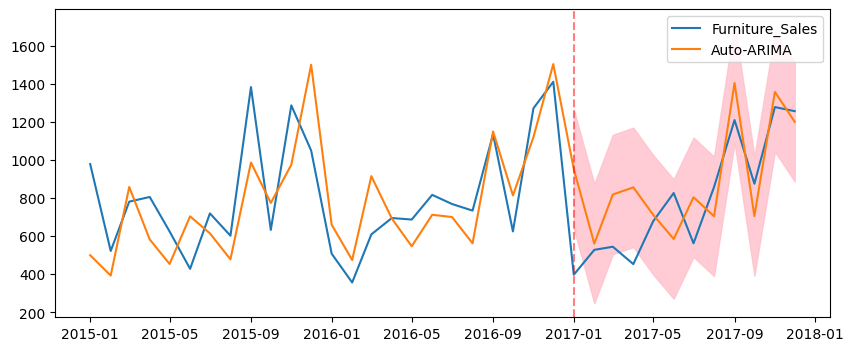

In [54]:
#plot
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(y.iloc[12:][['Furniture_Sales','Auto-ARIMA']],label= ['Furniture_Sales','Auto-ARIMA'])
ax.fill_between(test.index,lower,upper, color='pink',alpha=0.8)
plt.axvline(test.index[0],c='red',alpha=0.5, ls='--')
ax.legend()

In [ ]:
with open('/content/drive/MyDrive/TimeSeriesProjects/models/Auto-ARIMA.pckl', 'wb') as fout: # saving the model in models directory
    pickle.dump(model3, fout)

##Facebook Prophet

In [63]:
!pip install prophet

In [64]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [65]:
##For Prophet we need time-series in a very particular format i,e; 2 columns (ds,y)
fbp = y[['Furniture_Sales']].copy()
fbp.columns = ['y']
fbp['ds'] = fbp.index
fbp.head()
fbp = fbp.iloc[:,[1,0]]
fbp.head()

,ds,y
Order Date,,
2014-01-01,2014-01-01,480.194231
2014-02-01,2014-02-01,367.931600
2014-03-01,2014-03-01,857.291529
2014-04-01,2014-04-01,567.488357
2014-05-01,2014-05-01,432.049188


In [66]:
fbp.tail()

,ds,y
Order Date,,
2017-08-01,2017-08-01,857.881889
2017-09-01,2017-09-01,1209.508583
2017-10-01,2017-10-01,875.362728
2017-11-01,2017-11-01,1277.817759
2017-12-01,2017-12-01,1256.298672


In [67]:
#Split
fbptrain = fbp.iloc[:-12]
fbptest = fbp.iloc[-12:]

###Since Prophet has time as regressor
###Hence it has no problem dealing with missing data

In [74]:
#Creating model
mod_furniture = Prophet()
mod_furniture.fit(fbptrain)
future = mod_furniture.make_future_dataframe(periods= 12,freq='MS')
#future is a datadrame of dates
future.head()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpigpdp152/086eg9dl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpigpdp152/hb28oh73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82628', 'data', 'file=/tmp/tmpigpdp152/086eg9dl.json', 'init=/tmp/tmpigpdp152/hb28oh73.json', 'output', 'file=/tmp/tmpigpdp152/prophet_modelftqa6q_x/prophet_model-20231006123820.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:38:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
0,2014-01-01
1,2014-02-01
2,2014-03-01
3,2014-04-01
4,2014-05-01


In [75]:
forecast_furniture = mod_furniture.predict(future)
forecast_furniture.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,681.587747,489.001179,783.155528,681.587747,681.587747,-47.448368,-47.448368,-47.448368,-47.448368,-47.448368,-47.448368,0.0,0.0,0.0,634.139379
1,2014-02-01,685.635861,262.636833,555.371574,685.635861,685.635861,-274.074947,-274.074947,-274.074947,-274.074947,-274.074947,-274.074947,0.0,0.0,0.0,411.560915
2,2014-03-01,689.292223,587.719489,880.524017,689.292223,689.292223,42.431306,42.431306,42.431306,42.431306,42.431306,42.431306,0.0,0.0,0.0,731.723529
3,2014-04-01,693.340337,498.459461,803.704992,693.340337,693.340337,-34.565318,-34.565318,-34.565318,-34.565318,-34.565318,-34.565318,0.0,0.0,0.0,658.775020
4,2014-05-01,697.257867,381.823496,672.804972,697.257867,697.257867,-165.309770,-165.309770,-165.309770,-165.309770,-165.309770,-165.309770,0.0,0.0,0.0,531.948097


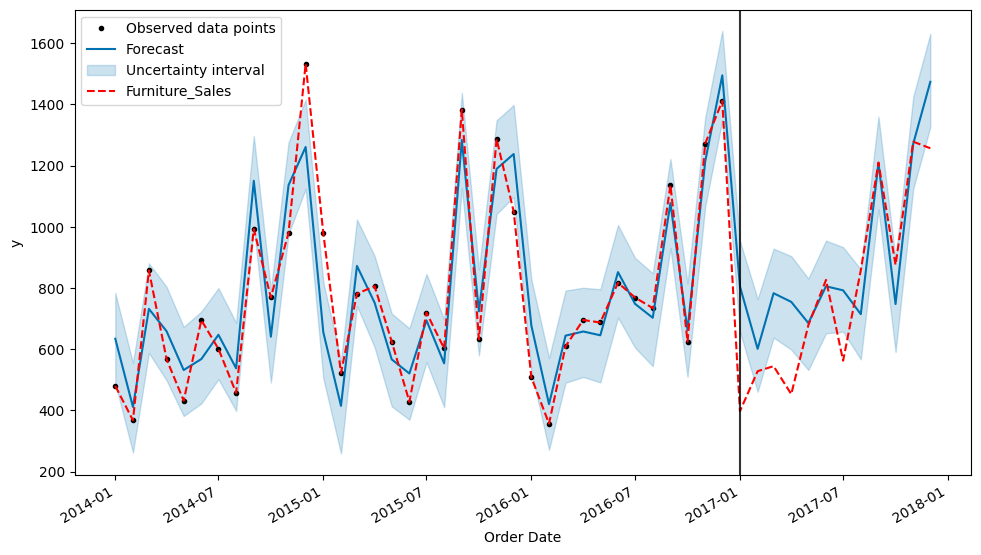

In [76]:
mod_furniture.plot(forecast_furniture)
y['Furniture_Sales'].plot(c='red',ls='--')
plt.axvline(test.index[0],c='black',alpha=0.8)
plt.legend();

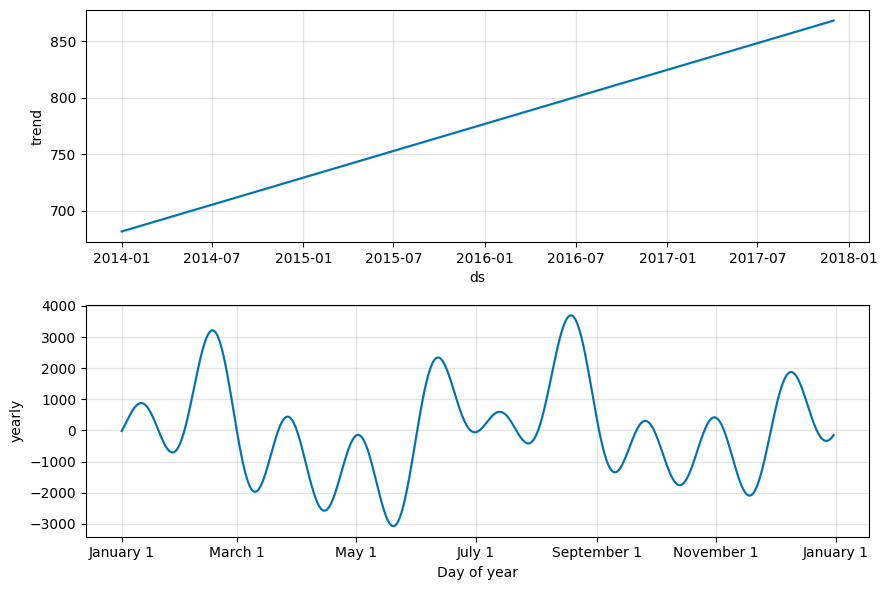

In [77]:
mod_furniture.plot_components(forecast_furniture);

In [78]:
y['Prophet'] = forecast_furniture.yhat.to_numpy()

In [87]:
with open('/content/drive/MyDrive/TimeSeriesProjects/models/fbprophet.pckl', 'wb') as fout: # saving the model in models directory
    pickle.dump(mod_furniture, fout)

In [ ]:
#Cross-Validation of Prophet
cutoffs = pd.date_range(start='2015-01-01', end='2016-10-01', freq='1MS')
print(cutoffs)

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01'],
              dtype='datetime64[ns]', freq='MS')


In [ ]:
df_cv = cross_validation(
    mod_furniture,
    horizon = '60 days', #forecast
    cutoffs = cutoffs
)

  0%|          | 0/22 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpep2yyynl/9bzi6w1x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpep2yyynl/rykey7p_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33167', 'data', 'file=/tmp/tmpep2yyynl/9bzi6w1x.json', 'init=/tmp/tmpep2yyynl/rykey7p_.json', 'output', 'file=/tmp/tmpep2yyynl/prophet_modelzaoih1ab/prophet_model-20231006094643.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:46:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:47:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpep2yyynl/bb4yt5yo.json
DEBUG:cmdstanpy:input tempfil

In [ ]:
df_cv = df_cv[~df_cv.ds.duplicated(keep='last')]
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-02-01,-412.327600,-430.895106,-392.420283,522.395667,2015-01-01
2,2015-03-01,3555.404468,3555.404464,3555.404472,781.236437,2015-02-01
4,2015-04-01,730.061804,730.061801,730.061808,805.822962,2015-03-01
5,2015-05-01,469.508754,469.508751,469.508756,624.996700,2015-04-01
6,2015-06-01,3066.842676,3066.842674,3066.842677,428.565500,2015-05-01
7,2015-07-01,1618.870828,1613.349598,1623.459365,719.706316,2015-06-01
8,2015-08-01,690.178517,688.383781,692.110133,602.412012,2015-07-01
9,2015-09-01,1497.143525,1496.768045,1497.565640,1382.790684,2015-08-01
10,2015-10-01,768.011415,767.584069,768.488734,632.980184,2015-09-01
11,2015-11-01,711.122860,710.541446,711.634143,1286.701354,2015-10-01


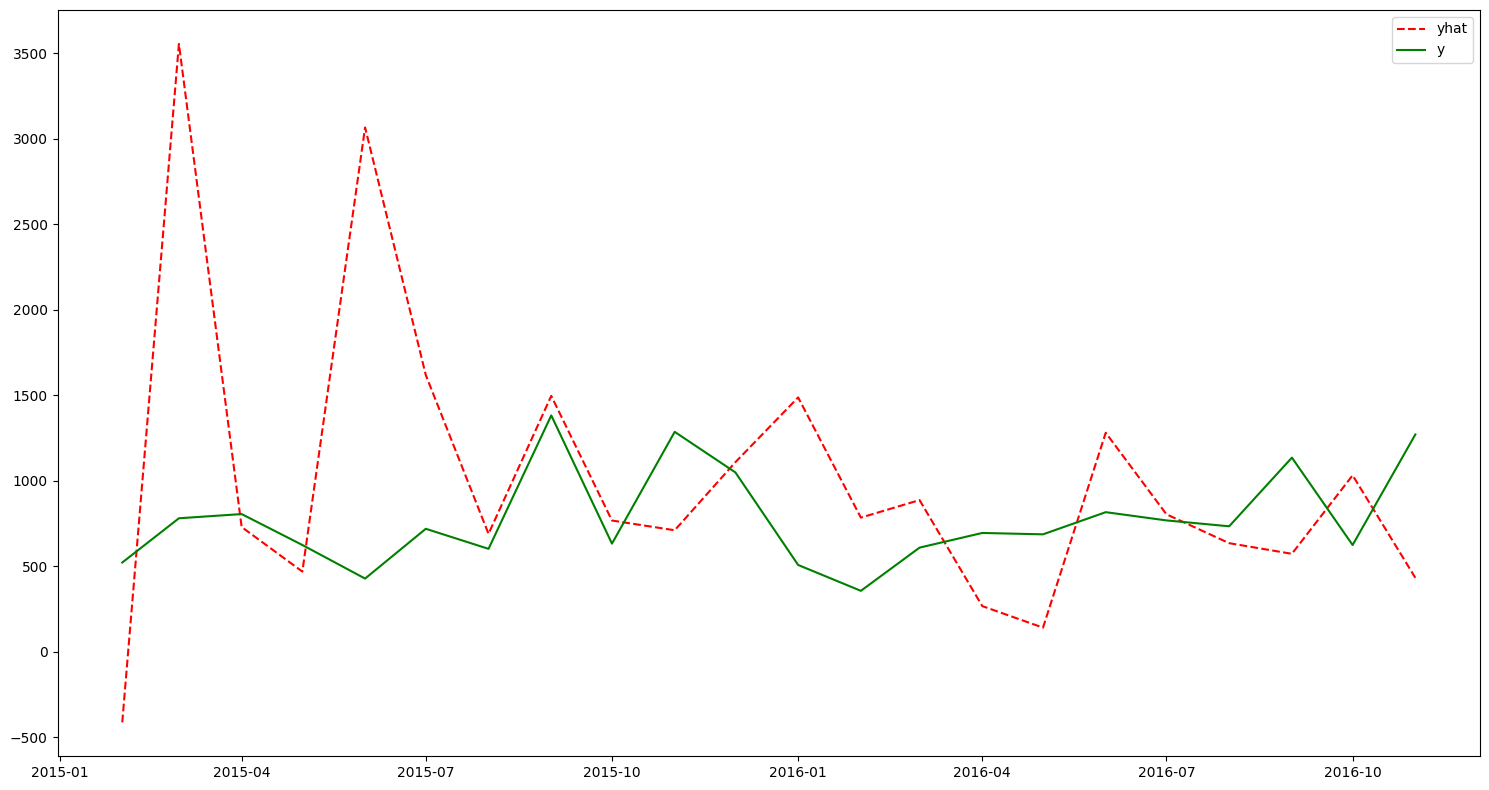

In [ ]:
fig,ax = plt.subplots(figsize=(15,8))
plt.plot(df_cv.ds,df_cv.yhat,color='red',ls='--', label='yhat')
plt.plot(df_cv.ds,df_cv.y,color='green', label='y')
plt.legend()
plt.tight_layout()
plt.show();

In [ ]:
pm = performance_metrics(df_cv)
pm

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,29 days,3.886649e+06,1971.458575,1526.089022,2.003534,2.003534,0.825396,0.000000
1,30 days,1.885208e+05,434.189819,319.806794,0.465908,0.248782,0.450760,0.142857
2,31 days,8.279008e+05,909.890555,632.777210,1.101201,0.568543,0.711414,0.076923


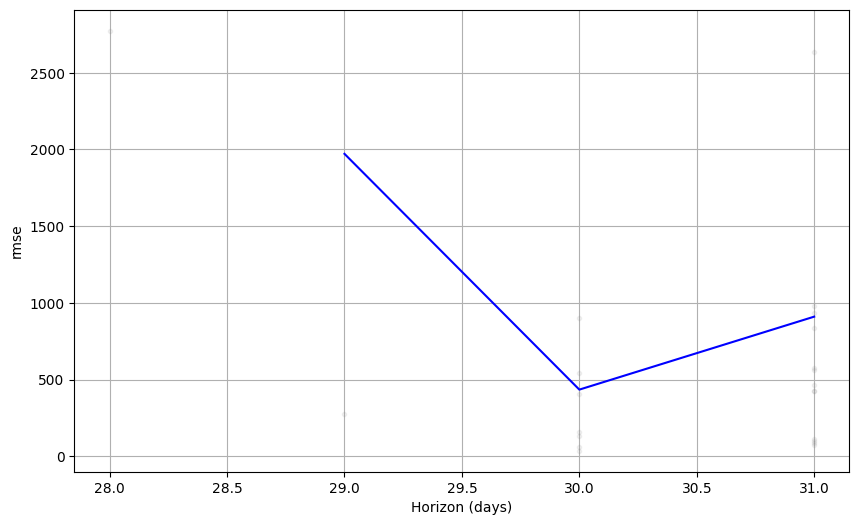

In [ ]:
plot_cross_validation_metric(df_cv, metric='rmse');

##Add exogenous variable: Discount

In [ ]:
Discount = df[df['Category']=='Furniture'].groupby(['Order Date'])[['Discount']].mean()
Discount = Discount[['Discount']].resample('MS').mean()
Discount.shape

(48, 1)

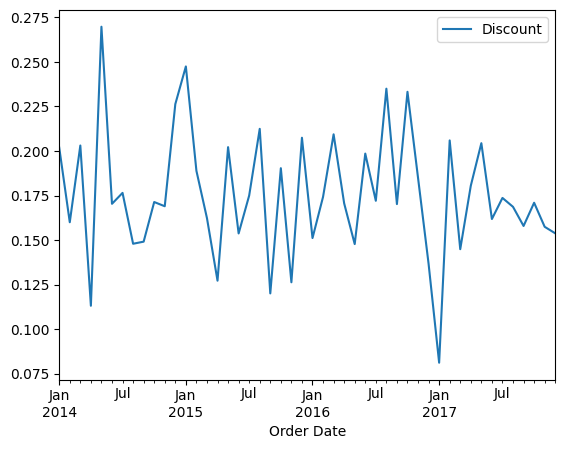

In [ ]:
Discount.plot();

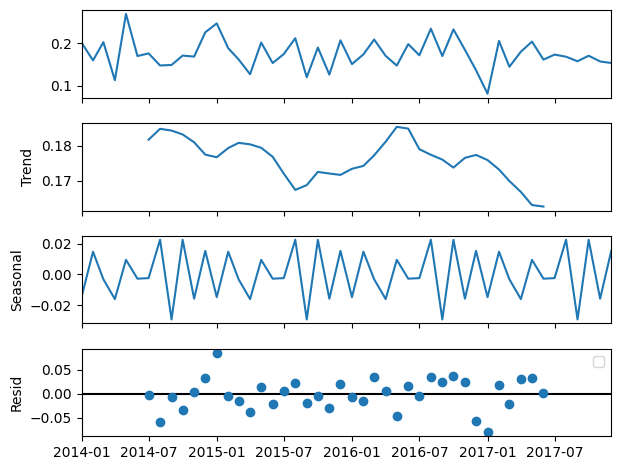

In [ ]:
decompose = seasonal_decompose(Discount,model='additive',period=12)
decompose.plot()
plt.legend()
plt.show();

In [ ]:
fbp.head()

,ds,y
Order Date,,
2014-01-01,2014-01-01,480.194231
2014-02-01,2014-02-01,367.931600
2014-03-01,2014-03-01,857.291529
2014-04-01,2014-04-01,567.488357
2014-05-01,2014-05-01,432.049188


In [ ]:
fbp = pd.concat([fbp,np.round(Discount['Discount'],2)],axis=1)
fbp.reset_index(drop=True,inplace=True)
fbp.head()

,ds,y,Discount
0,2014-01-01,480.194231,0.20
1,2014-02-01,367.931600,0.16
2,2014-03-01,857.291529,0.20
3,2014-04-01,567.488357,0.11
4,2014-05-01,432.049188,0.27


In [ ]:
train = fbp.iloc[:-12]
test = fbp.iloc[-12:]

In [ ]:
#Prophet model with exogenous variable
model5 = Prophet()
model5.add_regressor('Discount', mode='additive')
model5.fit(train)
future = model5.make_future_dataframe(periods=12, freq='MS')
future.head()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpep2yyynl/e34k2ca1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpep2yyynl/b26c1ov_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88770', 'data', 'file=/tmp/tmpep2yyynl/e34k2ca1.json', 'init=/tmp/tmpep2yyynl/b26c1ov_.json', 'output', 'file=/tmp/tmpep2yyynl/prophet_modelqc7vo4hz/prophet_model-20231006095048.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:50:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:50:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
0,2014-01-01
1,2014-02-01
2,2014-03-01
3,2014-04-01
4,2014-05-01


In [ ]:
future.loc[train.index,'Discount'] = train['Discount'].to_numpy()
future.loc[test.index,'Discount'] = test['Discount'].to_numpy()
future.head()

,ds,Discount
0,2014-01-01,0.20
1,2014-02-01,0.16
2,2014-03-01,0.20
3,2014-04-01,0.11
4,2014-05-01,0.27


In [ ]:
forecast = model5.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Discount,Discount_lower,Discount_upper,additive_terms,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,698.049228,463.276058,729.615096,698.049228,698.049228,38.238637,38.238637,38.238637,-94.062866,...,38.238637,38.238637,38.238637,-132.301503,-132.301503,-132.301503,0.0,0.0,0.0,603.986362
1,2014-02-01,701.650059,273.920092,549.832478,701.650059,701.650059,-36.171683,-36.171683,-36.171683,-294.472263,...,-36.171683,-36.171683,-36.171683,-258.300579,-258.300579,-258.300579,0.0,0.0,0.0,407.177796
2,2014-03-01,704.902423,620.053303,901.886147,704.902423,704.902423,38.238637,38.238637,38.238637,58.246836,...,38.238637,38.238637,38.238637,20.008199,20.008199,20.008199,0.0,0.0,0.0,763.149258
3,2014-04-01,708.503253,478.663446,755.045422,708.503253,708.503253,-129.184584,-129.184584,-129.184584,-85.528939,...,-129.184584,-129.184584,-129.184584,43.655645,43.655645,43.655645,0.0,0.0,0.0,622.974315
4,2014-05-01,711.987929,501.154551,775.603769,711.987929,711.987929,168.456697,168.456697,168.456697,-73.682005,...,168.456697,168.456697,168.456697,-242.138702,-242.138702,-242.138702,0.0,0.0,0.0,638.305923


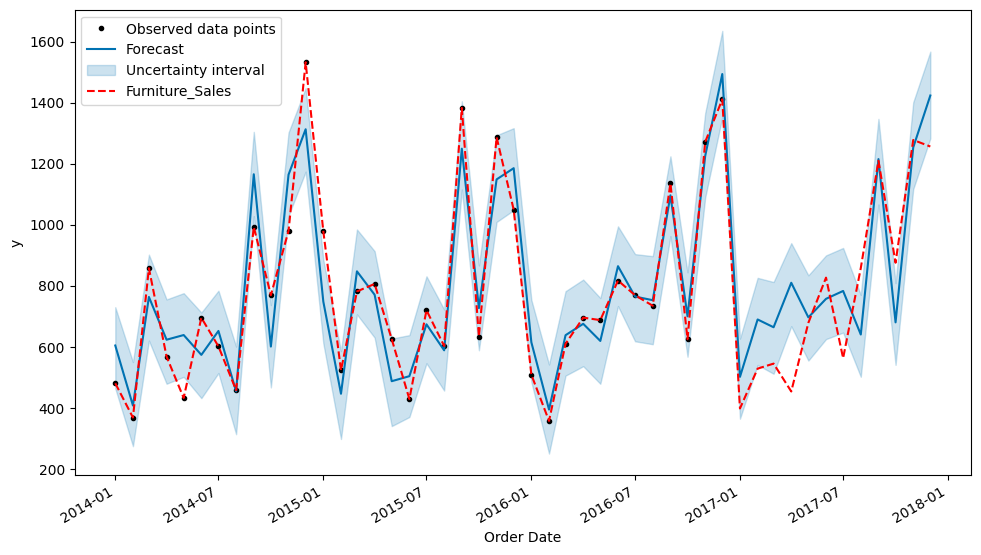

In [ ]:
model5.plot(forecast)
y['Furniture_Sales'].plot(color='red', ls='--')
plt.legend()
plt.show();

In [ ]:
y['Prophet_with_exo_var'] = forecast['yhat'].to_numpy()
y.head()

,Furniture_Sales,difference,Naive_Sales,"ARIMA(0,1,1)_Sales","SARIMA(1, 1, 2)x(0, 1, 1, 12)",Auto-ARIMA,Prophet,Prophet_with_exo_var
Order Date,,,,,,,,
2014-01-01,480.194231,NaN,NaN,0.000000,0.000000,41.432996,634.139379,603.986362
2014-02-01,367.931600,-112.262631,480.194231,451.645165,346.010636,41.432996,411.560915,407.177796
2014-03-01,857.291529,489.359929,367.931600,408.149470,469.549284,41.432996,731.723529,763.149258
2014-04-01,567.488357,-289.803172,857.291529,586.810788,583.076231,41.432996,658.775020,622.974315
2014-05-01,432.049188,-135.439170,567.488357,580.045677,805.752892,41.432996,531.948097,638.305923


In [ ]:
with open('/content/drive/MyDrive/TimeSeriesProjects/models/fbprophet_exo_var.pckl', 'wb') as fout: # saving the model in models directory
    pickle.dump(model5, fout)

##VARMA model

In [ ]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
#Columns we don't need for time series analysis
columns= ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID',
       'Product Name', 'Sub-Category', 'Quantity', 'Discount', 'Profit']
df1 = df.drop(columns, axis=1)
df1 = df1.sort_values(by='Order Date')
df1.head()

,Order Date,Category,Sales
7980,2014-01-03,Office Supplies,16.448
739,2014-01-04,Office Supplies,11.784
740,2014-01-04,Office Supplies,272.736
741,2014-01-04,Office Supplies,3.540
1759,2014-01-05,Office Supplies,19.536


In [ ]:
df1['Category'].unique()

array(['Office Supplies', 'Furniture', 'Technology'], dtype=object)

In [ ]:
dfos = df1[df1['Category']=='Office Supplies']
dft = df1[df1['Category']=='Technology']

In [ ]:
dfos = dfos.groupby(['Order Date'])[['Sales']].sum()
dfos.head()

,Sales
Order Date,
2014-01-03,16.448
2014-01-04,288.060
2014-01-05,19.536
2014-01-06,685.340
2014-01-07,10.430


In [ ]:
dft = dft.groupby(['Order Date'])[['Sales']].sum()
dft.head()

,Sales
Order Date,
2014-01-06,1147.94
2014-01-09,31.20
2014-01-13,646.74
2014-01-15,149.95
2014-01-16,124.20


In [ ]:
#Resampling of furniture sales by months: 'MS'
dfosmean = dfos[['Sales']].resample('MS').mean()
dfosmean.columns = ['Office_supplies_sales']
dfosmean.head()

,Office_supplies_sales
Order Date,
2014-01-01,285.357647
2014-02-01,63.042588
2014-03-01,391.176318
2014-04-01,464.794750
2014-05-01,324.346545


In [ ]:
#Resampling of furniture sales by months: 'MS'
dftmean = dft[['Sales']].resample('MS').mean()
dftmean.columns = ['Technology_sales']
dftmean.head()

,Technology_sales
Order Date,
2014-01-01,449.041429
2014-02-01,229.787143
2014-03-01,2031.948375
2014-04-01,613.028933
2014-05-01,564.698588


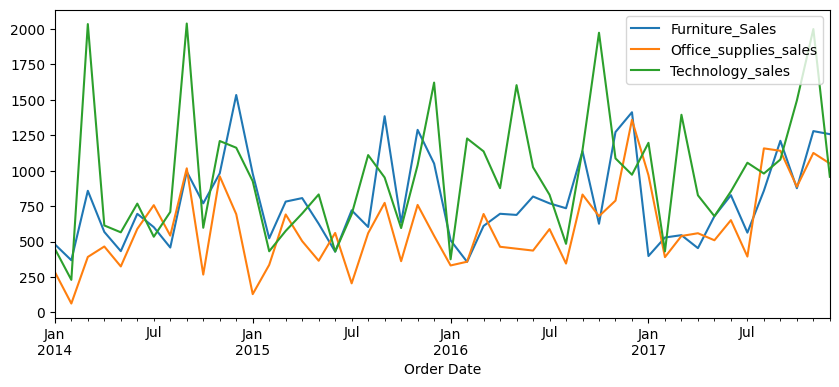

In [ ]:
y['Furniture_Sales'].plot(figsize=(10,4))
dfosmean['Office_supplies_sales'].plot()
dftmean['Technology_sales'].plot()
plt.legend()
plt.show();

In [ ]:
y['Office_supplies_sales'] = dfosmean['Office_supplies_sales']
y['Technology_sales'] = dftmean['Technology_sales']
y.head()

,Furniture_Sales,difference,Naive_Sales,"ARIMA(0,1,1)_Sales","SARIMA(1, 1, 2)x(0, 1, 1, 12)",Auto-ARIMA,Prophet,Prophet_with_exo_var,Office_supplies_sales,Technology_sales
Order Date,,,,,,,,,,
2014-01-01,480.194231,NaN,NaN,0.000000,0.000000,41.432996,634.139379,603.986362,285.357647,449.041429
2014-02-01,367.931600,-112.262631,480.194231,451.645165,346.010636,41.432996,411.560915,407.177796,63.042588,229.787143
2014-03-01,857.291529,489.359929,367.931600,408.149470,469.549284,41.432996,731.723529,763.149258,391.176318,2031.948375
2014-04-01,567.488357,-289.803172,857.291529,586.810788,583.076231,41.432996,658.775020,622.974315,464.794750,613.028933
2014-05-01,432.049188,-135.439170,567.488357,580.045677,805.752892,41.432996,531.948097,638.305923,324.346545,564.698588


In [ ]:
ntest =12
train = y[['Furniture_Sales','Office_supplies_sales','Technology_sales']].iloc[:-12]
test = y[['Furniture_Sales','Office_supplies_sales','Technology_sales']].iloc[-12:]

In [ ]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
train = pd.DataFrame(train_scaled, index=train.index, columns=['Furniture_Sales','Office_supplies_sales','Technology_sales'])
test = pd.DataFrame(test_scaled, index=test.index, columns=['Furniture_Sales','Office_supplies_sales','Technology_sales'])
scaled_y = pd.concat([train,test])
scaled_y.head()

,Furniture_Sales,Office_supplies_sales,Technology_sales
Order Date,,,
2014-01-01,-0.995174,-0.981563,-1.054901
2014-02-01,-1.364805,-1.837979,-1.534900
2014-03-01,0.246438,-0.573921,2.410453
2014-04-01,-0.707754,-0.290323,-0.695894
2014-05-01,-1.153694,-0.831367,-0.801700


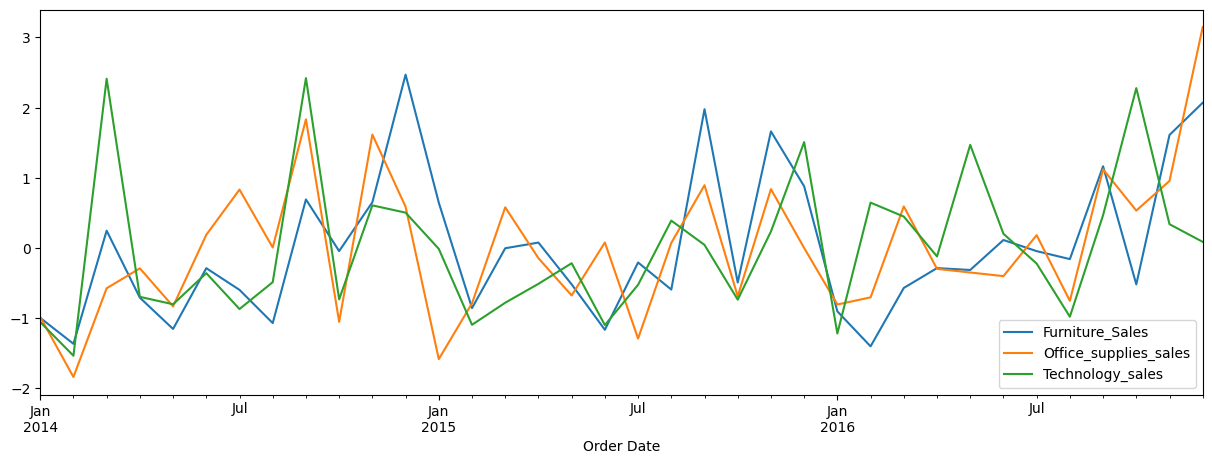

In [ ]:
train.plot(figsize=(15,5));

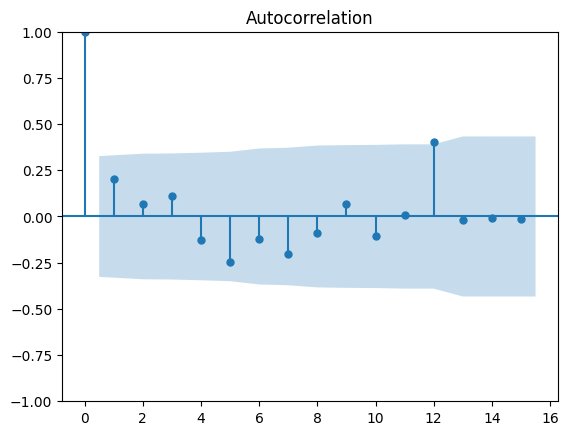

In [ ]:
#Plots
plot_acf(train['Furniture_Sales'].dropna(),lags=15);

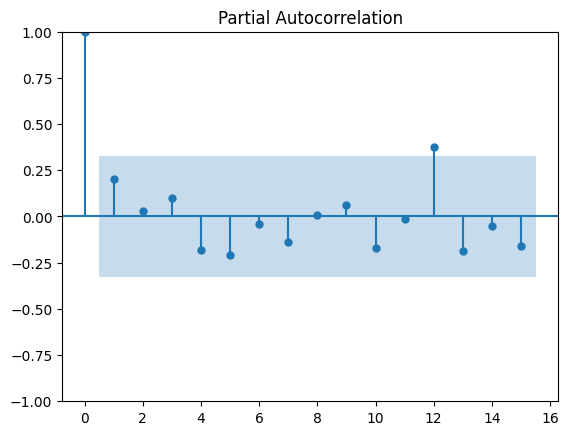

In [ ]:
plot_pacf(train['Furniture_Sales'].dropna(),lags=15);

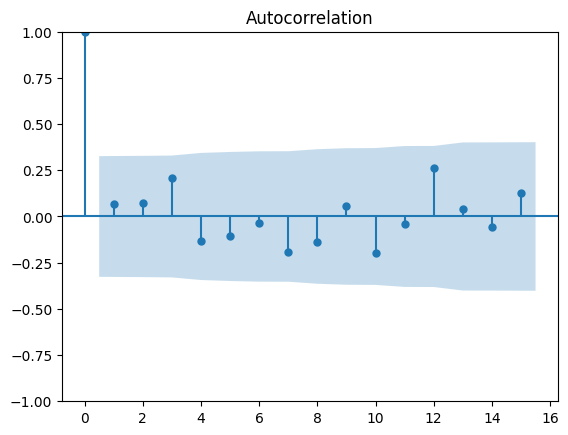

In [ ]:
plot_acf(train['Office_supplies_sales'].dropna(),lags=15);

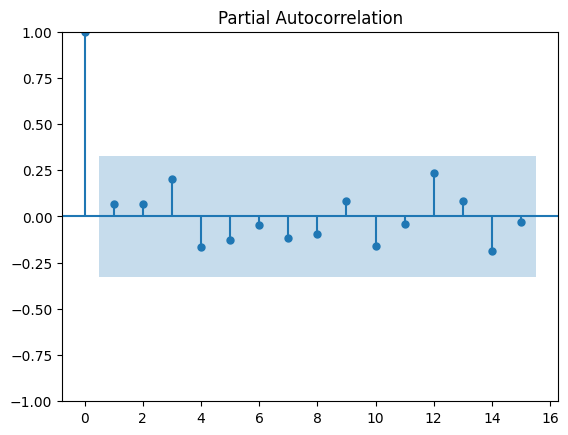

In [ ]:
plot_pacf(train['Office_supplies_sales'].dropna(),lags=15);

In [ ]:
cols = ['Furniture_Sales','Office_supplies_sales','Technology_sales']

In [ ]:
p=q=range(0,8)
pq = list(itertools.product(p,q))[1:]

In [ ]:
AIC = 1000000
order = (20,20)
for param in pq:
  model6 = VARMAX(train[cols],
                     order=param,
                     )
  res3 = model6.fit()

  if res3.aic < AIC:
    AIC = res3.aic
    order = param
print(f'VARMA{order} - AIC: ', AIC)
model_name = f'VARMA{order}_Sales'

VARMA(0, 5) - AIC:  297.8485178132912


In [ ]:
model6 = VARMAX(train[cols],order=order)
res3 = model6.fit(maxiter=10000)
print(res3.summary())
print(res3.params)

                                                  Statespace Model Results                                                  
Dep. Variable:     ['Furniture_Sales', 'Office_supplies_sales', 'Technology_sales']   No. Observations:                   36
Model:                                                                       VMA(5)   Log Likelihood                 -76.779
                                                                        + intercept   AIC                            261.557
Date:                                                              Fri, 06 Oct 2023   BIC                            347.067
Time:                                                                      10:19:02   HQIC                           291.402
Sample:                                                                  01-01-2014                                         
                                                                       - 12-01-2016                                         


In [ ]:
fit = res3.fittedvalues

In [ ]:
forecast3 = res3.forecast(12)

In [ ]:
f= res3.get_forecast(12)
f.conf_int()

,lower Furniture_Sales,lower Office_supplies_sales,lower Technology_sales,upper Furniture_Sales,upper Office_supplies_sales,upper Technology_sales
2017-01-01,-0.187181,-4.770856,-2.853477,3.065953,-2.516515,0.844348
2017-02-01,-3.599092,-4.568962,-0.732917,-0.268900,-1.817986,3.352220
2017-03-01,-2.944339,-0.545506,-1.972730,0.558495,3.127576,2.197585
2017-04-01,-1.768776,-2.677408,-2.649732,1.934449,1.461475,1.635561
2017-05-01,-2.409199,-3.205838,-2.525709,1.410094,1.681322,2.136426
2017-06-01,-2.310847,-2.895388,-2.355779,2.299786,2.747079,2.392824
2017-07-01,-2.310847,-2.895388,-2.355779,2.299786,2.747079,2.392824
2017-08-01,-2.310847,-2.895388,-2.355779,2.299786,2.747079,2.392824
2017-09-01,-2.310847,-2.895388,-2.355779,2.299786,2.747079,2.392824
2017-10-01,-2.310847,-2.895388,-2.355779,2.299786,2.747079,2.392824


In [ ]:
Furniture_Sales_l,Office_supplies_sales_l,Technology_sales_l,Furniture_Sales_u,Office_supplies_sales_u,Technology_sales_u = f.conf_int().iloc[:,0],f.conf_int().iloc[:,1],f.conf_int().iloc[:,2],f.conf_int().iloc[:,3],f.conf_int().iloc[:,4],f.conf_int().iloc[:,5]

In [ ]:
pred = pd.concat([fit,forecast3])
pred.rename(columns={'Furniture_Sales':'Furniture_SalesPred','Office_supplies_sales':'Office_supplies_salesPred', 'Technology_sales':'Technology_salesPred'},inplace=True)
pred.head()

,Furniture_SalesPred,Office_supplies_salesPred,Technology_salesPred
2014-01-01,-0.005531,-0.074155,0.018523
2014-02-01,-0.138200,0.273658,0.010656
2014-03-01,-0.859034,0.496425,0.004691
2014-04-01,-0.493010,0.330571,-0.250871
2014-05-01,0.000717,0.971213,-0.571457


In [ ]:
scaled_y['VARMA(1,1)_Furniture_Sales'] = pred['Furniture_SalesPred'].to_numpy()
scaled_y['VARMA(1,1)_Office_supplies_sales'] = pred['Office_supplies_salesPred'].to_numpy()
scaled_y['VARMA(1,1)_Technology_sales'] = pred['Technology_salesPred'].to_numpy()

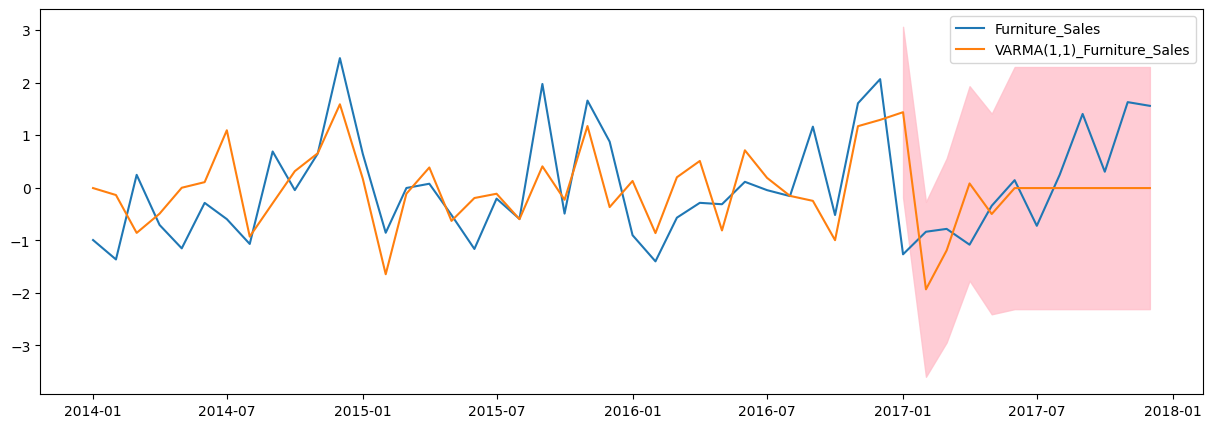

In [ ]:
fig,ax=plt.subplots(figsize=(15,5))
ax.plot(scaled_y[['Furniture_Sales','VARMA(1,1)_Furniture_Sales']], label=['Furniture_Sales','VARMA(1,1)_Furniture_Sales'])
ax.fill_between(test.index, Furniture_Sales_l, Furniture_Sales_u, alpha=0.8, color='pink')
ax.legend();

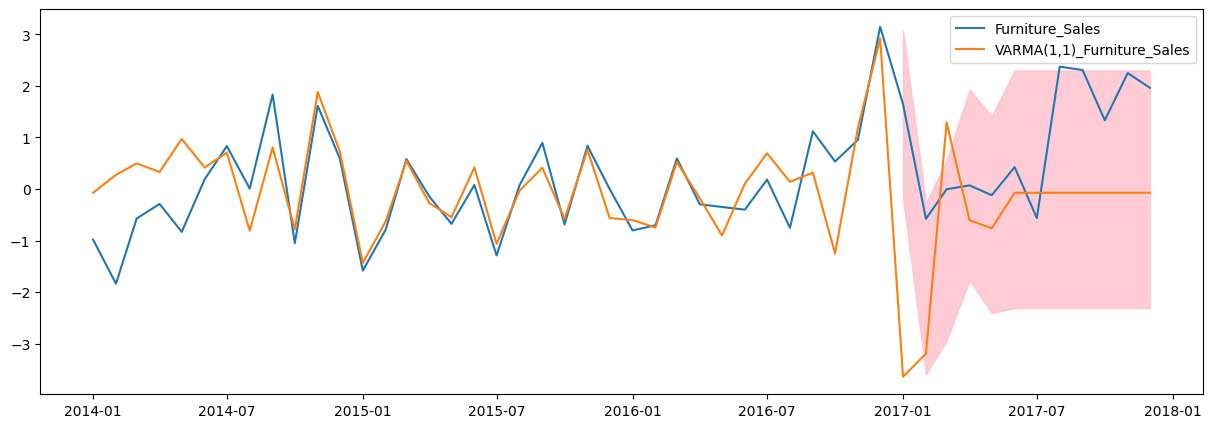

In [ ]:
fig,ax=plt.subplots(figsize=(15,5))
ax.plot(scaled_y[['Office_supplies_sales','VARMA(1,1)_Office_supplies_sales']], label=['Furniture_Sales','VARMA(1,1)_Furniture_Sales'])
ax.fill_between(test.index, Furniture_Sales_l, Furniture_Sales_u, alpha=0.8, color='pink')
ax.legend();

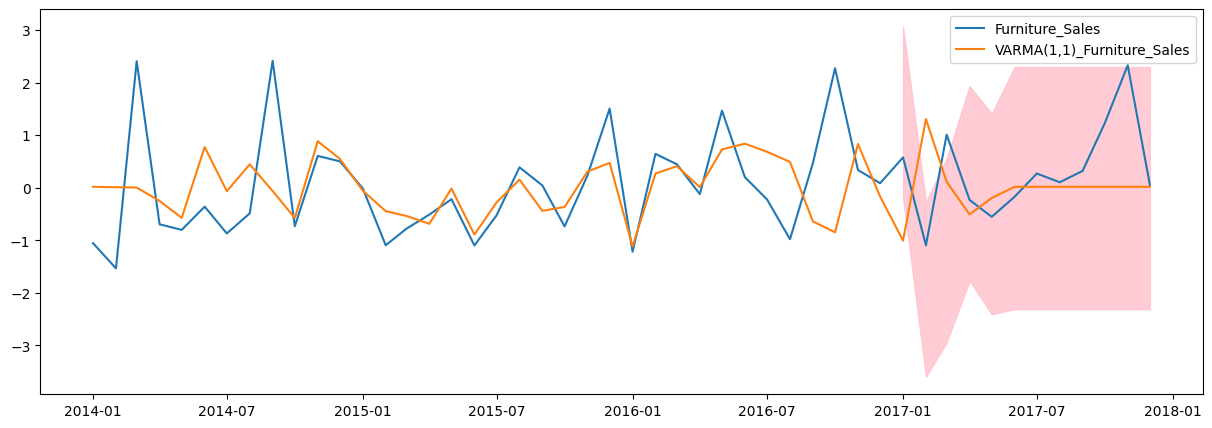

In [ ]:
fig,ax=plt.subplots(figsize=(15,5))
ax.plot(scaled_y[['Technology_sales','VARMA(1,1)_Technology_sales']], label=['Furniture_Sales','VARMA(1,1)_Furniture_Sales'])
ax.fill_between(test.index, Furniture_Sales_l, Furniture_Sales_u, alpha=0.8, color='pink')
ax.legend();

In [ ]:
with open('/content/drive/MyDrive/TimeSeriesProjects/models/VARMA.pckl', 'wb') as fout: # saving the model in models directory
    pickle.dump(model6, fout)

##Evaluation of R2_score and rmse for all the model

In [ ]:
#R2_scores
columns = ['Naive_Sales', 'ARIMA(0,1,1)_Sales',
       'SARIMA(1, 1, 2)x(0, 1, 1, 12)', 'Auto-ARIMA', 'Prophet','Prophet_with_exo_var']
for col in columns:
  print(f'R2_score: {col} ==>',r2_score(	y_true= y.iloc[1:]['Furniture_Sales'],y_pred= y.iloc[1:][col]))
print(f'R2_score: {"VARMA(1,1)_Furniture_Sales"} ==>',r2_score(	y_true= scaled_y.iloc[1:]['Furniture_Sales'], y_pred= scaled_y.iloc[1:]['VARMA(1,1)_Furniture_Sales']))
print(f'R2_score: {"VARMA(1,1)_Office_supplies_sales"} ==>',r2_score(	y_true= scaled_y.iloc[1:]['Office_supplies_sales'], y_pred= scaled_y.iloc[1:]['VARMA(1,1)_Office_supplies_sales']))
print(f'R2_score: {"VARMA(1,1)_Technology_sales"} ==>',r2_score(	y_true= scaled_y.iloc[1:]['Technology_sales'], y_pred= scaled_y.iloc[1:]['VARMA(1,1)_Technology_sales']))

print('*********************************************************************')

for col in columns:
  print(f'rmse_score: {col} ==>',np.sqrt(mean_squared_error(y.iloc[1:]['Furniture_Sales'],y.iloc[1:][col])))
print('*********************************************************************')
print('Scaled sales values')
print(f'rmse_score: {"VARMA(1,1)_Furniture_Sales"} ==>',np.sqrt(mean_squared_error(scaled_y.iloc[1:]['Furniture_Sales'], scaled_y.iloc[1:]['VARMA(1,1)_Furniture_Sales'])))
print(f'rmse_score: {"VARMA(1,1)_Office_supplies_sales"} ==>',np.sqrt(mean_squared_error(scaled_y.iloc[1:]['Office_supplies_sales'], scaled_y.iloc[1:]['VARMA(1,1)_Office_supplies_sales'])))
print(f'rmse_score: {"VARMA(1,1)_Technology_sales"} ==>',np.sqrt(mean_squared_error(scaled_y.iloc[1:]['Technology_sales'], scaled_y.iloc[1:]['VARMA(1,1)_Technology_sales'])))


##Based on the r2_score and rmse values. Facebook Prophet model with addition of exogenous variable gives the best prediction of furniture sales values.

##Predicting sales for Office supplies and Technology

In [ ]:
office = y[['Office_supplies_sales']]
technology = y[['Technology_sales']]

In [ ]:
p= q = range(0,5)
d =range(0,2)
pdq = list(itertools.product(p,d,q))
print(pdq)
P = Q = range(0,2)
D =range(0,2)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P,D,Q))]
print(seasonal_pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 0, 4), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 0, 3), (4, 0, 4), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


##Office_supplies sales

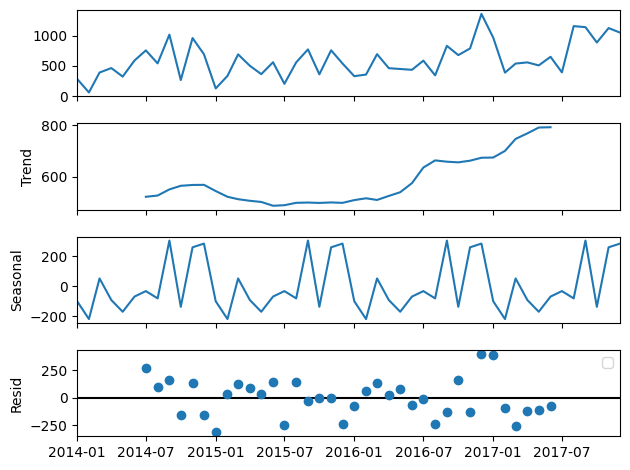

In [ ]:
decompose = seasonal_decompose(office,model='additive',period=12)
decompose.plot()
plt.legend()
plt.show();

In [ ]:
#Data split
train = office.iloc[:-12]
test = office.iloc[-12:]

In [ ]:
AIC = 1000000
order = (10,10,10)
season_order = (10,10,10,12)
for param in pdq:
  for seasonal_param in seasonal_pdq:
    model7 = SARIMAX(train['Office_supplies_sales'],
                     order=param,
                     seasonal_order=seasonal_param,
                     enforce_stationarity=False,
                     )
    res = model7.fit()

    if res.aic < AIC:
      AIC = res.aic
      order = param
      season_order = seasonal_param
print(f'SARIMA{order}x{season_order} - AIC: ', AIC)
model_name = f'SARIMA{order}x{season_order}'

SARIMA(2, 1, 4)x(0, 1, 1, 12) - AIC:  91.65851993442782


In [ ]:
model7 = SARIMAX(train['Office_supplies_sales'],
                     order=order,
                     seasonal_order=season_order,
                     enforce_stationarity=False,
                     )
result = model7.fit()
print(result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                Office_supplies_sales   No. Observations:                   36
Model:             SARIMAX(2, 1, 4)x(0, 1, [1], 12)   Log Likelihood                 -37.829
Date:                              Fri, 06 Oct 2023   AIC                             91.659
Time:                                      09:56:26   BIC                             89.993
Sample:                                  01-01-2014   HQIC                            84.990
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7454      4.295     -0.406      0.684     -10.163       6.672
ar.L2         -1.34

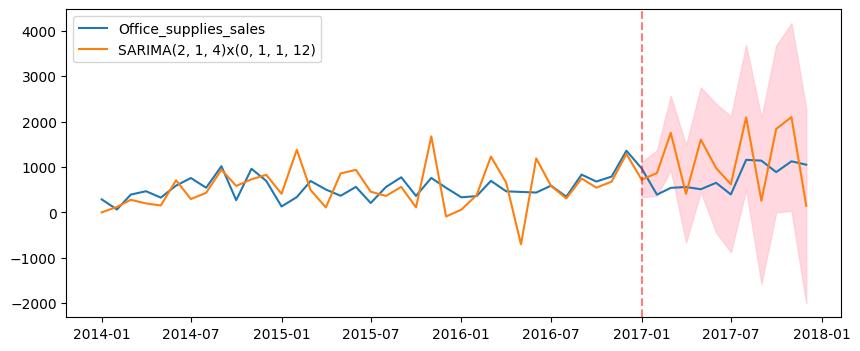

In [ ]:
plot_fit_and_forecast(office, result, 'Office_supplies_sales', model_name)

##Prophet

In [ ]:
office_y = office[['Office_supplies_sales']]
office_y.reset_index(inplace=True)
office_y.columns = ['ds','y']
office_y.head()

,ds,y
0,2014-01-01,285.357647
1,2014-02-01,63.042588
2,2014-03-01,391.176318
3,2014-04-01,464.794750
4,2014-05-01,324.346545


In [ ]:
train = office_y.iloc[:-12]
test = office_y.iloc[-12:]

In [ ]:
#Creating model
model8 = Prophet()
model8.fit(train)
future = model8.make_future_dataframe(periods= 12,freq='MS')
forecast = model8.predict(future)
forecast.head()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpep2yyynl/vl6jwn12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpep2yyynl/lpjhxcoc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53175', 'data', 'file=/tmp/tmpep2yyynl/vl6jwn12.json', 'init=/tmp/tmpep2yyynl/lpjhxcoc.json', 'output', 'file=/tmp/tmpep2yyynl/prophet_model9cn9a8qh/prophet_model-20231006095726.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:57:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:57:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,662.389855,23.748251,302.312619,662.389855,662.389855,-496.832017,-496.832017,-496.832017,-496.832017,-496.832017,-496.832017,0.0,0.0,0.0,165.557838
1,2014-02-01,662.642137,-21.226787,234.052214,662.642137,662.642137,-555.043878,-555.043878,-555.043878,-555.043878,-555.043878,-555.043878,0.0,0.0,0.0,107.598259
2,2014-03-01,662.870005,449.475353,712.749852,662.870005,662.870005,-87.162335,-87.162335,-87.162335,-87.162335,-87.162335,-87.162335,0.0,0.0,0.0,575.707670
3,2014-04-01,663.122287,333.542711,605.656582,663.122287,663.122287,-195.318416,-195.318416,-195.318416,-195.318416,-195.318416,-195.318416,0.0,0.0,0.0,467.803871
4,2014-05-01,663.366431,228.898323,489.234527,663.366431,663.366431,-307.524617,-307.524617,-307.524617,-307.524617,-307.524617,-307.524617,0.0,0.0,0.0,355.841814


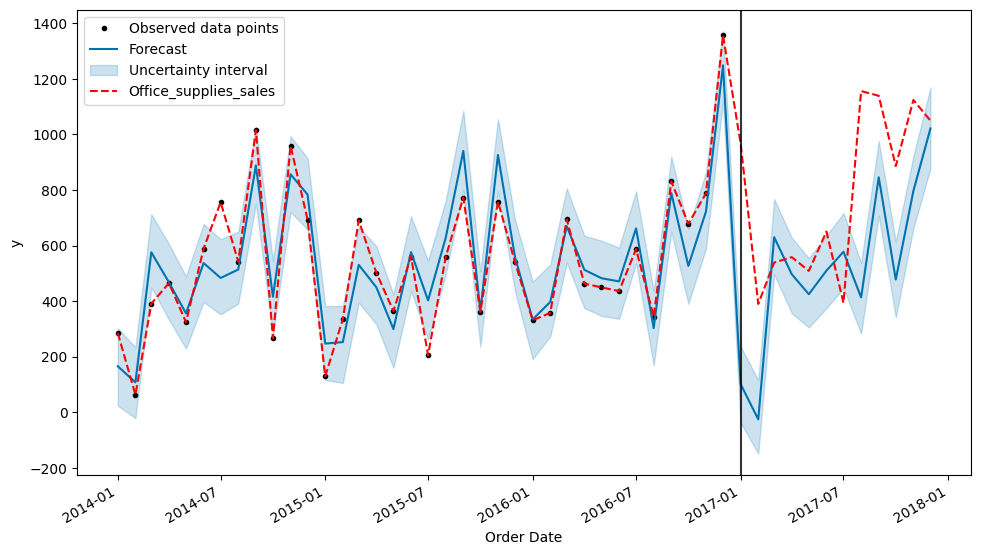

In [ ]:
model8.plot(forecast)
office['Office_supplies_sales'].plot(c='red',ls='--')
plt.axvline(office.index[-12],c='black',alpha=0.8)
plt.legend();

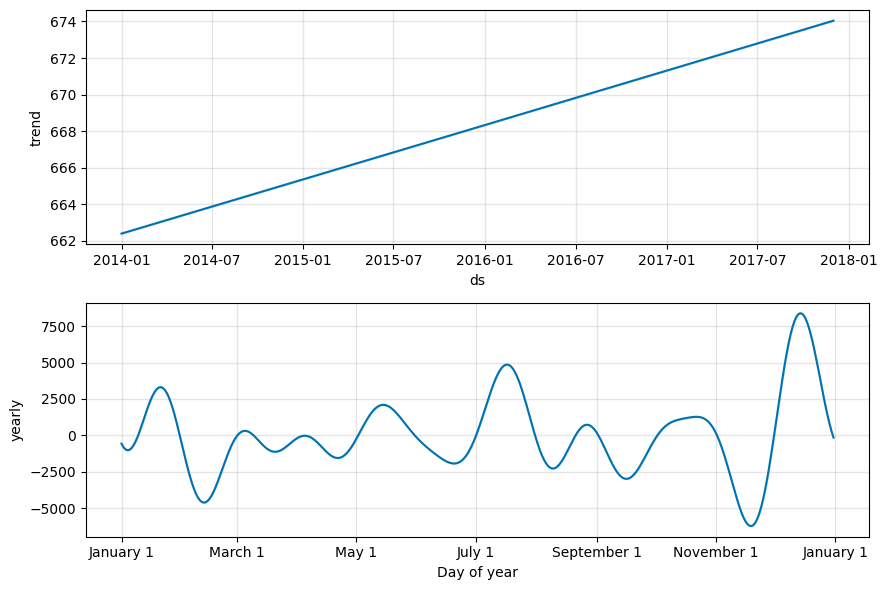

In [ ]:
model8.plot_components(forecast);

In [ ]:
office['Prophet'] = forecast.yhat.to_numpy()

In [ ]:
office.head()

,Office_supplies_sales,"SARIMA(2, 1, 4)x(0, 1, 1, 12)",Prophet
Order Date,,,
2014-01-01,285.357647,0.000000,165.557838
2014-02-01,63.042588,119.334279,107.598259
2014-03-01,391.176318,276.770345,575.707670
2014-04-01,464.794750,195.788917,467.803871
2014-05-01,324.346545,150.982497,355.841814


#Model evaluation using R2_score and root mean squared error (rmse)

In [ ]:
columns = office.columns
for cols in columns[1:]:
  print(f'R2_score: {cols} ==>',r2_score(	y_true= office.iloc[1:]['Office_supplies_sales'], y_pred= office.iloc[1:][cols]))
print('**************************************************************************')

for cols in columns[1:]:
    print(f'rmse_score: {cols} ==>',np.sqrt(mean_squared_error(office.iloc[1:]['Office_supplies_sales'], office.iloc[1:][cols])))



R2_score: SARIMA(2, 1, 4)x(0, 1, 1, 12) ==> -2.513093590538014
R2_score: Prophet ==> 0.4054970144262807
**************************************************************************
rmse_score: SARIMA(2, 1, 4)x(0, 1, 1, 12) ==> 536.4276750988552
rmse_score: Prophet ==> 220.67002070424843


##Technoloy_supplies

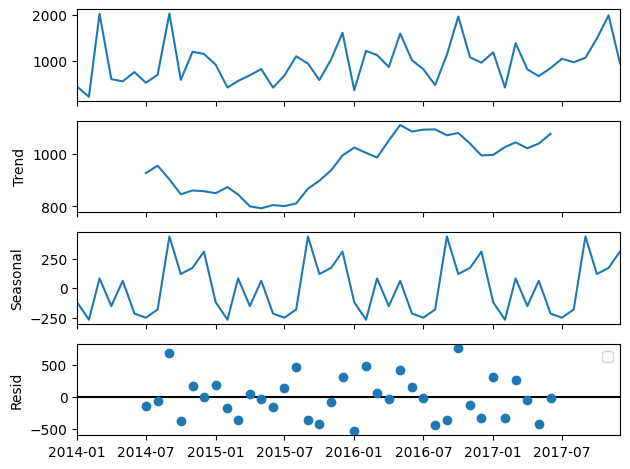

In [ ]:
decompose = seasonal_decompose(technology,model='additive',period=12)
decompose.plot()
plt.legend()
plt.show();

In [ ]:
train = technology.iloc[:-12]
test = technology.iloc[-12:]

In [ ]:
#SARIMA model
AIC = 1000000
order = (10,10,10)
season_order = (10,10,10,12)
for param in pdq:
  for seasonal_param in seasonal_pdq:
    model = SARIMAX(train['Technology_sales'],
                     order=param,
                     seasonal_order=seasonal_param,
                     enforce_stationarity=False,
                     )
    res = model.fit()

    if res.aic < AIC:
      AIC = res.aic
      order = param
      season_order = seasonal_param
print(f'SARIMA{order}x{season_order} - AIC: ', AIC)
model_name = f'SARIMA{order}x{season_order}'

SARIMA(2, 1, 4)x(0, 1, 1, 12) - AIC:  93.92818525379532


In [ ]:
model9 = SARIMAX(train['Technology_sales'],
                     order=order,
                     seasonal_order=season_order,
                     enforce_stationarity=False,
                     )
result = model9.fit()
print(result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                     Technology_sales   No. Observations:                   36
Model:             SARIMAX(2, 1, 4)x(0, 1, [1], 12)   Log Likelihood                 -38.964
Date:                              Fri, 06 Oct 2023   AIC                             93.928
Time:                                      10:00:56   BIC                             92.262
Sample:                                  01-01-2014   HQIC                            87.259
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2324      1.215     -0.191      0.848      -2.613       2.149
ar.L2         -1.14

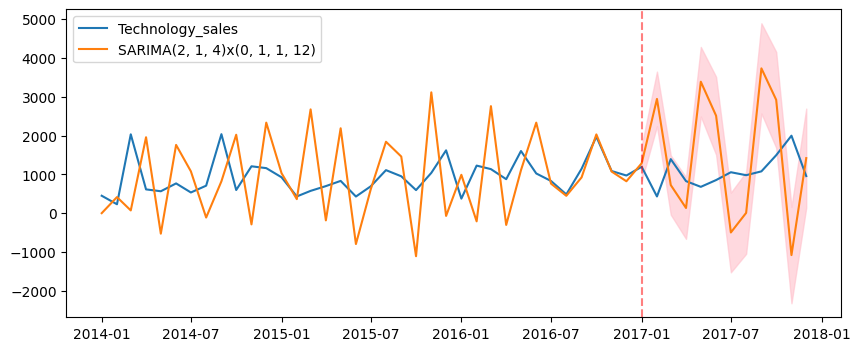

In [ ]:
plot_fit_and_forecast(technology, result, 'Technology_sales', model_name)

##Prophet

In [ ]:
technology_y = technology[['Technology_sales']]
technology_y.reset_index(inplace=True)
technology_y.columns = ['ds','y']
technology_y.head()

,ds,y
0,2014-01-01,449.041429
1,2014-02-01,229.787143
2,2014-03-01,2031.948375
3,2014-04-01,613.028933
4,2014-05-01,564.698588


In [ ]:
train = technology_y.iloc[:-12]
test = technology_y.iloc[-12:]

In [ ]:
#Creating model
model10 = Prophet()
model10.fit(train)
future = model10.make_future_dataframe(periods= 12,freq='MS')
forecast = model10.predict(future)
forecast.head()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpep2yyynl/i07zbehd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpep2yyynl/tjiw4nom.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22577', 'data', 'file=/tmp/tmpep2yyynl/i07zbehd.json', 'init=/tmp/tmpep2yyynl/tjiw4nom.json', 'output', 'file=/tmp/tmpep2yyynl/prophet_modelvst0nz5r/prophet_model-20231006100057.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:00:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:00:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,1011.654793,407.839762,1072.077557,1011.654793,1011.654793,-266.928510,-266.928510,-266.928510,-266.928510,-266.928510,-266.928510,0.0,0.0,0.0,744.726283
1,2014-02-01,1016.528928,-93.946781,604.676589,1016.528928,1016.528928,-773.907027,-773.907027,-773.907027,-773.907027,-773.907027,-773.907027,0.0,0.0,0.0,242.621901
2,2014-03-01,1020.931373,811.975953,1549.087845,1020.931373,1020.931373,143.716393,143.716393,143.716393,143.716393,143.716393,143.716393,0.0,0.0,0.0,1164.647766
3,2014-04-01,1025.805508,300.758414,1022.778730,1025.805508,1025.805508,-357.786460,-357.786460,-357.786460,-357.786460,-357.786460,-357.786460,0.0,0.0,0.0,668.019048
4,2014-05-01,1030.522413,517.076180,1221.410168,1030.522413,1030.522413,-153.859261,-153.859261,-153.859261,-153.859261,-153.859261,-153.859261,0.0,0.0,0.0,876.663152


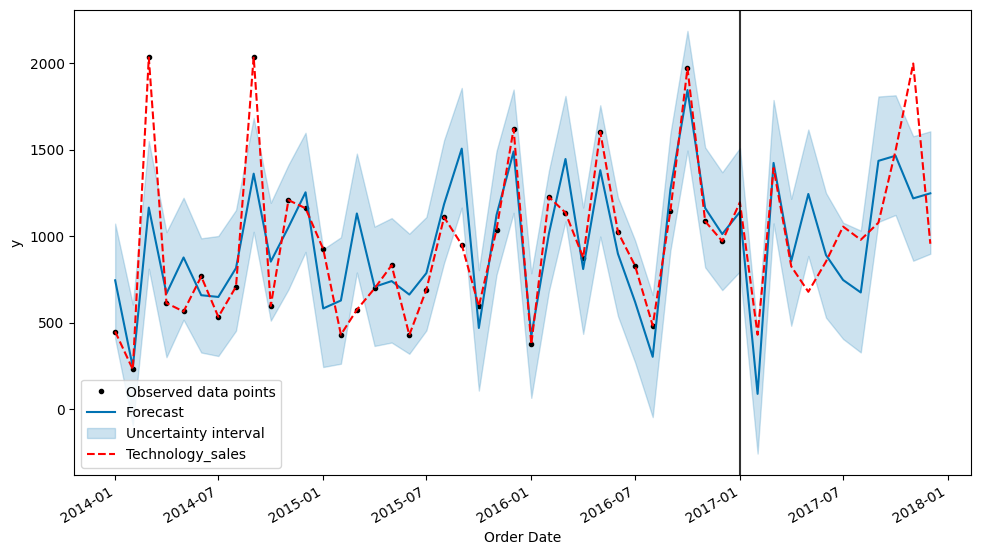

In [ ]:
model10.plot(forecast)
technology['Technology_sales'].plot(c='red',ls='--')
plt.axvline(technology.index[-12],c='black',alpha=0.8)
plt.legend();

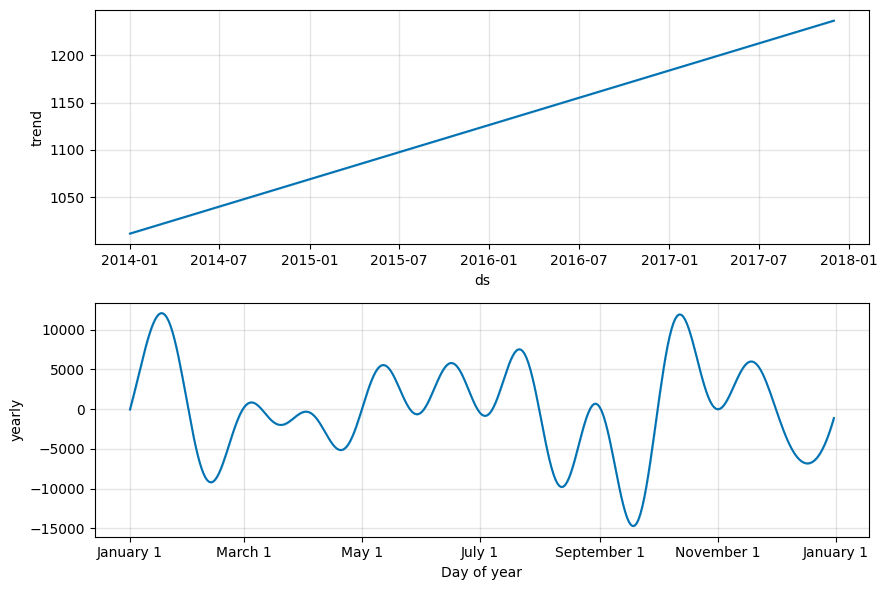

In [ ]:
model10.plot_components(forecast);

In [ ]:
technology['Prophet'] = forecast.yhat.to_numpy()

In [ ]:
technology.head()

,Technology_sales,"SARIMA(2, 1, 4)x(0, 1, 1, 12)",Prophet
Order Date,,,
2014-01-01,449.041429,0.000000,744.726283
2014-02-01,229.787143,414.259283,242.621901
2014-03-01,2031.948375,70.925691,1164.647766
2014-04-01,613.028933,1957.231978,668.019048
2014-05-01,564.698588,-527.968230,876.663152


#Model evaluation using R2_score and root mean squared error (rmse)

In [ ]:
columns = technology.columns
for cols in columns[1:]:
  print(f'R2_score: {cols} ==>',r2_score(	y_true= technology.iloc[1:]['Technology_sales'], y_pred= technology.iloc[1:][cols]))
print('**************************************************************************')

for cols in columns[1:]:
    print(f'rmse_score: {cols} ==>',np.sqrt(mean_squared_error(technology.iloc[1:]['Technology_sales'], technology.iloc[1:][cols])))



R2_score: SARIMA(2, 1, 4)x(0, 1, 1, 12) ==> -7.981053777679016
R2_score: Prophet ==> 0.5569958590545893
**************************************************************************
rmse_score: SARIMA(2, 1, 4)x(0, 1, 1, 12) ==> 1331.5732186967064
rmse_score: Prophet ==> 295.7367502457743
